In [217]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer
from qiskit.opflow import X,Y,Z,I
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import NumPyEigensolver
from qiskit.algorithms.optimizers import SLSQP, SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import EfficientSU2, PauliTwoDesign
from qiskit.quantum_info import Statevector

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator
from qiskit_optimization.runtime import VQEClient

In [218]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [219]:
from datetime import date, datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [220]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

In [221]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-15 18:48:07,227: Credentials are already in use. The existing account in the session will be replaced.


In [222]:
def add_param_rx(circuit, qubits, params_list):
    
    """method to add parameterized rx gates to a set of qubits"""
        
    for i,qubit in enumerate(qubits):
        circuit.rx(params_list[i],qubit)
        
def add_param_rz(circuit, qubits, params_list):
    
    """method to add parameterized rx gates to a set of qubits"""

    for i,qubit in enumerate(qubits):
        circuit.rz(params_list[i],qubit)
        
        
def add_param_ry(circuit, qubits, params_list):
    
    """method to add parameterized ry gates to a set of qubits"""
    
    for i,qubit in enumerate(qubits):
        circuit.ry(params_list[i],qubit)
        #Parameter("θ"+depth+str(i))
        
def add_cnot(circuit, control_qubit,target_qubit):
    
    """method to a cnot gates to two qubits"""
    
    circuit.cx(control_qubit, target_qubit)
    
def add_cnots(circuit, qubits):

    """method to add cnot gates to a set of qubits with periodic boundary conditions"""
    
    for i, qubit, in enumerate(qubits):
        if i+1 < len(qubits):
            add_cnot(circuit, qubit,qubits[i+1])
        else: 
            add_cnot(circuit,qubit, qubits[0])
            
def add_cnots_rev(circuit, qubits):

    """method to add cnot gates to a set of qubits with periodic boundary conditions"""
    
    for i, qubit, in enumerate(qubits):
        if abs(-1-i) <= len(qubits):
            add_cnot(circuit, qubits[-i],qubits[-1-i])
        else: 
            add_cnot(circuit,qubits[0], qubits[-1])
            
def construct_Ising_like_circ(num_qubits, rotation_blocks = 1):
    
    """method to create a circuit for an ansatz for Ising 1d model with periodic boundary conditions"""
    
    qr = QuantumRegister(num_qubits, "q") # create quantum register
    circuit = QuantumCircuit(qr) # create quantum circuit
    num_params = num_qubits * rotation_blocks * 4 # determine number of parameters
    gates_per_block = 2 * num_qubits
    params_list = ParameterVector("θ", length=num_params) # initialize a list of parameters

    
    for rotation in range(rotation_blocks): 
        starting_param = rotation * gates_per_block
        #add_param_rx(circuit, circuit.qubits, params_list[starting_param:starting_param+num_qubits]) # create first layer of rx gates
        add_param_ry(circuit, circuit.qubits, params_list[starting_param:starting_param+num_qubits])  # create second layer of ry gates
        add_param_rx(circuit, circuit.qubits, params_list[starting_param+num_qubits:starting_param+2*num_qubits])  # create third layer of rx gates
        
        if rotation % 2 == 0: 
            add_cnots(circuit, circuit.qubits) # add layer of entangling cnot gates
            
        else: 
            add_cnots_rev(circuit, circuit.qubits) 
            
    
    #add_param_rx(circuit, circuit.qubits, params_list[starting_param+3*num_qubits:starting_param+4*num_qubits])  # create fourth layer of rx gates
    add_param_ry(circuit, circuit.qubits, params_list[starting_param+2*num_qubits:starting_param+3*num_qubits])  # create fifth layer of ry gates
    add_param_rx(circuit, circuit.qubits, params_list[starting_param+3*num_qubits:starting_param+4*num_qubits]) # create sixth layer of rx gates
        
    return circuit
        
def create_measurements(circuit, qubits, cbits):
    for i, qubit in enumerate(qubits):
        circuit.measure(qubit, cbits[i]) 

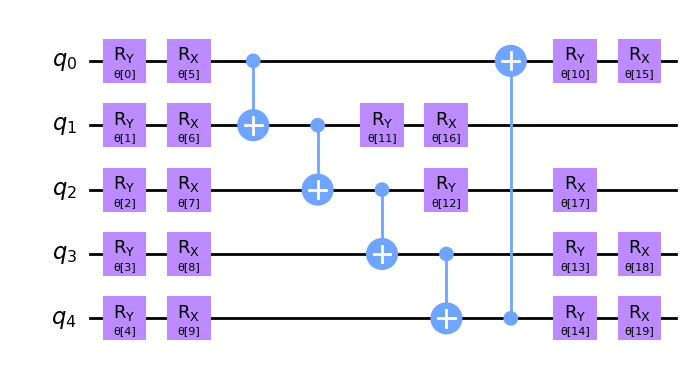

In [223]:
num_qubits = 5
circuit = construct_Ising_like_circ(num_qubits, rotation_blocks = 1)
circuit.draw("mpl")

In [224]:
def construct_Ising_H_1D(num_qubits, g): 
    
    """Method to construct 1d transverse Ising Hamiltonian for n qubits"""
    
    H = 0  # start with a zero hamiltonian
    
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i != pos: # if not same position then tensor identity
                term = term ^ I
            elif i == pos: # if same position tensor pauli x
                term = term ^ X
                
        H += g * term # add term to hamiltonian for every qubit
        
        
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i == pos: # if same position tensor pauli z
                term = term ^ Z
            elif i == pos + 1: # if neighboring qubit tensor pauli z
                term = term ^ Z
            elif i + num_qubits - 1 == pos:  # periodic boundary conditions: link nth qubit to first qubit
                term = term^Z
            else:  # otherwise tensor identity
                term = term ^ I
                
        if pos == num_qubits - 1 and num_qubits == 2:  # if only two qubits ensure terms aren't repeated
            break
                
                    
        H += term
        
    return -H        

In [225]:
construct_Ising_H_1D(3, 0.1)

PauliSumOp(SparsePauliOp(['XII', 'IXI', 'IIX', 'ZZI', 'IZZ', 'ZIZ'],
              coeffs=[-0.1+0.j, -0.1+0.j, -0.1+0.j, -1. +0.j, -1. +0.j, -1. +0.j]), coeff=1.0)

In [226]:
def construct_correlation(num_qubits): 
    
    """Method to construct correlation matrix"""
    
    C = 0
        
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i == pos: # if same position tensor pauli z
                term = term ^ Z
            elif i == pos + 1: # if neighboring qubit tensor pauli z
                term = term ^ Z
            elif i + num_qubits - 1 == pos:  # periodic boundary conditions: link nth qubit to first qubit
                term = term^Z
            else:  # otherwise tensor identity
                term = term ^ I
                
        if pos == num_qubits - 1 and num_qubits == 2:  # if only two qubits ensure terms aren't repeated
            break
                
                    
        C += term
        
    return C 

In [227]:
construct_correlation(6)

PauliSumOp(SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)

In [228]:
def construct_Ising_H_1D_frustration(num_qubits, g): 
    
    """Method to construct 1d transverse Ising Hamiltonian for n qubits"""
    
    H = 0  # start with a zero hamiltonian
    
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i != pos: # if not same position then tensor identity
                term = term ^ I
            elif i == pos: # if same position tensor pauli x
                term = term ^ X
                
        H += -g * term # add term to hamiltonian for every qubit
        
        
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i == pos: # if same position tensor pauli z
                term = term ^ Z
            elif i == pos + 1: # if neighboring qubit tensor pauli z
                term = term ^ Z
            elif i + num_qubits - 1 == pos:  # periodic boundary conditions: link nth qubit to first qubit
                term = term^Z
            else:  # otherwise tensor identity
                term = term ^ I
                
        if pos == num_qubits - 1 and num_qubits == 2:  # if only two qubits ensure terms aren't repeated
            break
                
                    
        H += term
        
    return H        

In [229]:
construct_Ising_H_1D_frustration(3,0.1)

PauliSumOp(SparsePauliOp(['XII', 'IXI', 'IIX', 'ZZI', 'IZZ', 'ZIZ'],
              coeffs=[-0.1+0.j, -0.1+0.j, -0.1+0.j,  1. +0.j,  1. +0.j,  1. +0.j]), coeff=1.0)

In [230]:
def construct_magnetization(num_qubits): 
    
    M = 0 
    
    for pos in range(num_qubits):
        term = 1
        for i in range(num_qubits):
            if i != pos:
                term = term ^ I
            elif i == pos:
                term = term ^ Z
                
        M += term
    
    return M

In [231]:
construct_magnetization(6)

PauliSumOp(SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)

In [232]:
def construct_Ising_H_2D(x_dim, y_dim, g): 
    
    
    H = 0
    
    num_qubits = x_dim * y_dim 
    
    for pos in range(num_qubits):
        term = 1
        for i in range(num_qubits):
            if i != pos:
                term = term ^ I
            elif i == pos:
                term = term ^ X
                
        H += g* term
        
    for i in range(num_qubits): 
        
        x_pos = i % x_dim
        y_pos = i // x_dim
        
        flagx = False
        flagy = False
        
        for k in range(2): 
        
            term = 1

            for qubit_xpos in range(x_dim):
                for qubit_ypos in range(y_dim):
                    
                    if qubit_xpos == x_pos and qubit_ypos == y_pos:
                        term = term ^ Z
                    elif qubit_xpos == (x_pos + 1) and qubit_ypos == y_pos and k == 0 and not flagx:
                        term = term ^ Z
                        flagx = True

                    elif x_pos == x_dim - 1 and qubit_ypos == y_pos and k == 0 and not flagx:
                        term = term ^ Z
                        flagx = True

                    elif qubit_xpos == x_pos and qubit_ypos == (y_pos + 1) and k == 1 and not flagy:
                        term = term ^ Z
                        flagy = True

                    elif qubit_xpos == x_pos and y_pos == y_dim - 1 and k == 1 and not flagy:
                        term = term ^ Z
                        flagy = True

                    else:
                        term = term ^ I 
                        
            if (x_dim <= 2) and x_pos == x_dim - 1 and k == 0: 
                term = 0
                
            elif (y_dim <= 2) and y_pos == y_dim - 1 and k == 1: 
                term = 0
                        
            H += term
        
    return -H

In [233]:
def store_data(gs, exact_energies, est_energies, exact_corrs, est_corrs, num_qubits, quantum = False):
    
    now = datetime.now()
    date = now.strftime("%m_%d_%Y")
    time = now.strftime("%H_%M_%S")
    
    folder_path = os.path.join(os.getcwd(), "data",date, time)
    
    os.makedirs(folder_path, exist_ok = True)
    
    data = {"gs": gs, "Exact Energies": exact_energies, "Estimate Energies": est_energies,
           "Exact Correlations": exact_corrs, "Estimate Corr": est_corrs}
    
    frame = pd.DataFrame(data)
    
    if quantum:
    
        csv_path = os.path.join(folder_path, f"Sim_Results_{num_qubits}_quantum.csv")
        
    else:
    
        csv_path = os.path.join(folder_path, f"Sim_Results_{num_qubits}_statevector.csv")
        
    frame.to_csv(csv_path)

In [234]:
def load_data(file_path):
    
    df = pd.read_csv(file_path, index_col = False)

    gs = np.array(df["gs"])
    exact_energies = np.array([df["Exact Energies"]])
    est_energies = np.array([df["Estimate Energies"]])
    exact_corrs = np.array([df["Exact Correlations"]])
    est_corrs = np.array([df["Estimate Correlations"]])
    
    
    return gs, exact_energies, est_energies, exact_corrs, est_corrs
    

In [235]:
def get_exact_results(max_g, min_g, num_qubits,
             loop_iters = 11, store = True, verbose = False): 
    
    gs = []
    exact_energies = []
    exact_corrs = []
    
    for g in 10**np.linspace(min_g,max_g,loop_iters):

        g = np.round(g,3)

        if verbose:
            print(f"Solving Ising Hamiltonian with g={g}")

        Ham = construct_Ising_H_1D(num_qubits, g)
        l, v = np.linalg.eig(np.array(Operator(Ham)))
        idx = np.argmin(l)
        ground_state = Statevector(v[:,idx])
        exact_energies.append(l[idx])

        exact_corr = np.matmul(np.transpose(np.conjugate(ground_state)), np.matmul(corr_mat, ground_state))
        exact_corrs.append(exact_corr/num_qubits)

        if verbose: 
            print(f"Exact Energy: {l[idx]:.3f}")
            print(f"Exact Correlation: {exact_corr/num_qubits:.3f}")
            
#     if store:
#         store_data(gs, exact_energies, exact_corrs, num_qubits)
        

    return gs, exact_energies, exact_corrs


In [236]:
def recreate_eigenstate(counts):

    zero = np.array([[1],[0]])
    one = np.array([[0],[1]])
    
    eigenstate = 0

    for state in counts.keys():

        vector = 1

        for term in state:

            if term == "1": 

                vector = np.kron(vector, one)

            else:
                vector = np.kron(vector, zero)

        eigenstate += vector * counts[state]
        
    return eigenstate

In [237]:
def correlate_counts(counts):
    
    correlation = 0
    
    for state in counts.keys():
        
        correlate = 0
        
        for idx, term in enumerate(state): 
 
            if idx + 1 < len(state):
                neighbor = idx + 1
                
            else: 
                neighbor = 0
            
            if term == state[neighbor]:   
                    correlate += 1 
                    
            else:    
                    correlate += -1
                   
        correlation += correlate * (counts[state] * counts[state])
        
    return correlation

In [238]:
def run_sim(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = 3, 
            shots = 10000, loop_iters = 11, store = True, verbose = False, inner_iters = 1, 
            quantum = False, minimize_circ = False):

    gs = []
    est_energies = []
    exact_energies = []
    est_corrs = []
    exact_corrs = []
    
    solver  = NumPyEigensolver()
    corr_mat = Operator(construct_correlation(num_qubits))

    if verbose: 
        print("Running VQE")
        print("================================================")
        
    for g in 10**np.linspace(min_g, max_g, loop_iters):
        
        if minimize_circ and (g  < 0.1 or g > 10):
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = 1)
            first_layer_params = np.zeros(num_qubits * 2)
            
        else:
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = rot_blocks)
            first_layer_params = np.zeros(num_qubits * 2 * (rot_blocks))
            
            
        val = min(0.01*g*np.pi/2, np.pi/2)
        #last_layer_rx = np.zeros(num_qubits)
        last_layer_ry = np.full(num_qubits, val)
        last_layer_rx2= np.zeros(num_qubits)
        init_params = np.concatenate((first_layer_params,last_layer_ry, last_layer_rx2))

        energies = []
        circ_params = []
        optimal_circs = []
        eigenstates = []

        g = np.round(g,3)

        if verbose:
            print(f"Running Ising Hamiltonian with g={g}")


        Ham = construct_Ising_H_1D(num_qubits, g)
        l, v = np.linalg.eig(np.array(Operator(Ham)))
        idx = np.argmin(l)
        ground_state = Statevector(v[:,idx])
        exact_energies.append(l[idx])

        exact_corr = np.matmul(np.transpose(np.conjugate(ground_state)), np.matmul(corr_mat, ground_state))
        exact_corrs.append(exact_corr/num_qubits)

        for j in range(inner_iters):
            
            if quantum:

                vqe = VQEClient(ansatz=circuit, optimizer=optimizer, 
                              initial_point = init_params, backend = backend, provider = provider, shots = shots, 
                               measurement_error_mitigation=False)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                eigenstates.append(result.eigenstate)
                
            else: 
                    
                estimator = Estimator()
                vqe = VQE(estimator = estimator, ansatz=circuit, optimizer=optimizer, 
                          initial_point = init_params)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                circ_params.append(result.optimal_parameters)
                optimal_circs.append(result.optimal_circuit)
    
        if not quantum:
    
            qc = optimal_circs[np.argmin(energies)].bind_parameters(circ_params[np.argmin(energies)])
            qc = qc.decompose()
            job = backend.run(qc, counts = shots)
            res = job.result()
            outputstate = res.get_statevector(qc, decimals=3)

        else:
            outputstate = Statevector(recreate_eigenstate(eigenstates[np.argmin(energies)]))
            

        gs.append(g)
        est_energies.append(np.min(energies))

        corr = np.matmul(np.transpose(np.conjugate(outputstate)), np.matmul(corr_mat, outputstate))
        est_corrs.append(corr/num_qubits)

        if verbose:
            print(f"Exact Energy: {l[idx]:.3f}, Estimate Energy: {np.min(energies):.3f}")
            print(f"Exact Correlation: {exact_corr/num_qubits:.3f}, Estimate Correlation: {corr/num_qubits:.3f}")
            
    if store:
        store_data(gs, exact_energies, est_energies, exact_corrs, est_corrs, num_qubits, quantum = quantum)

    return gs, exact_energies, est_energies, exact_corrs, est_corrs


In [239]:
def run_sim_frustration(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = 3, 
            shots = 10000, loop_iters = 11, store = True, verbose = False, inner_iters = 1, 
            quantum = False, minimize_circ = False):

    gs = []
    est_energies = []
    exact_energies = []
    est_corrs = []
    exact_corrs = []
    
    solver  = NumPyEigensolver()
    corr_mat = Operator(construct_correlation(num_qubits))

    if verbose: 
        print("Running VQE")
        print("================================================")
        
    for g in 10**np.linspace(min_g, max_g, loop_iters):
        
        if minimize_circ and (g  < 0.1 or g > 10):
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = 1)
            first_layer_params = np.zeros(num_qubits * 2)
            
        else:
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = rot_blocks)
            first_layer_params = np.zeros(num_qubits * 2 * (rot_blocks))
            
            
        val = min(0.01*g*np.pi/2, np.pi/2)
        #last_layer_rx = np.zeros(num_qubits)
        last_layer_ry = np.full(num_qubits, val)
        last_layer_rx2= np.zeros(num_qubits)
        init_params = np.concatenate((first_layer_params,last_layer_ry, last_layer_rx2))

        energies = []
        circ_params = []
        optimal_circs = []
        eigenstates = []

        g = np.round(g,3)

        if verbose:
            print(f"Running Ising Hamiltonian with g={g}")


        Ham = construct_Ising_H_1D_frustration(num_qubits, g)
        l, v = np.linalg.eig(np.array(Operator(Ham)))
        idx = np.argmin(l)
        ground_state = Statevector(v[:,idx])
        exact_energies.append(l[idx])

        exact_corr = np.matmul(np.transpose(np.conjugate(ground_state)), np.matmul(corr_mat, ground_state))
        exact_corrs.append(exact_corr/num_qubits)

        for j in range(inner_iters):
            
            if quantum:

                vqe = VQEClient(ansatz=circuit, optimizer=optimizer, 
                              initial_point = init_params, backend = backend, provider = provider, shots = shots, 
                               measurement_error_mitigation=False)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                eigenstates.append(result.eigenstate)
                
            else: 
                    
                estimator = Estimator()
                vqe = VQE(estimator = estimator, ansatz=circuit, optimizer=optimizer, 
                          initial_point = init_params)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                circ_params.append(result.optimal_parameters)
                optimal_circs.append(result.optimal_circuit)
    
        if not quantum:
    
            qc = optimal_circs[np.argmin(energies)].bind_parameters(circ_params[np.argmin(energies)])
            qc = qc.decompose()
            job = backend.run(qc, counts = shots)
            res = job.result()
            outputstate = res.get_statevector(qc, decimals=3)

        else:
            outputstate = Statevector(recreate_eigenstate(eigenstates[np.argmin(energies)]))
            

        gs.append(g)
        est_energies.append(np.min(energies))

        corr = np.matmul(np.transpose(np.conjugate(outputstate)), np.matmul(corr_mat, outputstate))
        est_corrs.append(corr/num_qubits)

        if verbose:
            print(f"Exact Energy: {l[idx]:.3f}, Estimate Energy: {np.min(energies):.3f}")
            print(f"Exact Correlation: {exact_corr/num_qubits:.3f}, Estimate Correlation: {corr/num_qubits:.3f}")
            
    if store:
        store_data(gs, exact_energies, est_energies, exact_corrs, est_corrs, num_qubits, quantum = quantum)

    return gs, exact_energies, est_energies, exact_corrs, est_corrs


In [251]:
def plot_correlations(num_qubits, gs, exact_corrs, est_corrs , quantum = False, 
                     fig = None, ax = None, colors = None, gs_q = None, exact_corrs_q = None, est_corrs_q = None):
    
    assert ((not quantum) or quantum  and 
            exact_corrs_q is not None and est_corrs_q is not None and gs_q is not None), "Quantum Arg but no Data"
    
    if ax is None and fig is None:
        fig,ax = plt.subplots()
    max_height = max(np.max(est_corrs), np.max(exact_corrs))
    min_height = min(np.min(est_corrs), np.min(exact_corrs))
    
    ax.plot(np.full(8, 1), np.linspace(min_height, max_height, 8), linestyle = "dashed", color = "red")
    
    if colors is None:
        ax.plot(gs, exact_corrs, color ="forestgreen", label = f"Exact Correlation - {num_qubits} qubits")
        ax.plot(gs, est_corrs,"k+", label = f"Estimated Correlation with Simulator - {num_qubits} qubits")
    
    else: 
        ax.plot(gs, exact_corrs, color = colors[0],label = f"Exact Correlation for {num_qubits} qubits")
        ax.plot(gs, est_corrs,"+",color = colors[1],
                label = f"Estimated Correlation with Simulator - {num_qubits} qubits")
        
    
    if quantum:
        ax.plot(gs_q, est_corrs_q,"mx", label = f"Estimated Correlation with IBM Oslo - {num_qubits} qubits")
        
    ax.set_xscale("log")
    ax.set_title("Correlation of the Ising Model", fontsize =24)
    ax.set_ylabel("Correlation", fontsize = 18)
    ax.set_xlabel("Strength of Transverse Field", fontsize =18)
    ax.legend(loc = "best", fontsize =14)
    fig.tight_layout()
    fig.set_size_inches(14, 10)
    
    return fig,ax

In [241]:
def plot_energies(num_qubits, gs, exact_energies, est_energies, quantum = False, 
                     fig = None, ax = None, colors = None, gs_q = None, exact_energies_q = None, 
                  est_energies_q = None, per_site = False):
    
    assert ((not quantum) or quantum  and 
            exact_corrs_q is not None and est_corrs_q is not None and gs_q is not None), "Quantum Arg but no Data"
    
    if ax is None and fig is None:
        fig,ax = plt.subplots()
        
    if not quantum: 
        max_height = max(np.max(est_energies), np.max(exact_energies))
        min_height = min(np.min(est_energies), np.min(exact_energies))

    else: 
        max_height = max(max(np.max(est_energies), np.max(exact_energies)), np.max(est_energies_q))
        min_height = min(min(np.min(est_energies), np.min(exact_energies)), np.min(exact_energies_q))
        
    ax.plot(np.full(8, 1), np.linspace(min_height, max_height, 8), linestyle = "dashed", color = "red")
    
    if colors is None:
        ax.plot(gs, exact_energies,label = f"Exact Energy - {num_qubits} qubits")
        ax.plot(gs, est_energies, "x", color ="forestgreen", 
                label = f"Estimated Energy with Simulator - {num_qubits} qubits")
        
    else: 
        ax.plot(gs, exact_energies, color = colors[0], label = f"Exact Energy for {num_qubits} qubits")
        ax.plot(gs, est_energies,"+",color = colors[1],label = f"Estimated Energy with Classical Simulator - {num_qubits} qubits")
        
    if quantum:
        ax.plot(gs_q, est_energies_q,"mx", label = f"Estimated Energy with IBM Oslo - {num_qubits} qubits")
        

    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.set_title("Energy of the Ising Model", fontsize = 24)
    if not per_site:
        ax.set_ylabel("Energy", fontsize = 18)
    else: 
        ax.set_ylabel("Energy per Site", fontsize = 18)
    ax.set_xlabel("Strength of Transverse Field", fontsize = 18)
    ax.legend(loc = "best", fontsize = 14)
    fig.set_size_inches(14, 10)
    fig.tight_layout()
    
    return fig, ax

In [242]:
def write_text(fig,ax, ord_text_coords, dis_text_coords, arrow_coords, label_coords):
    ax.text(ord_text_coords[0],ord_text_coords[1], "Ordered Regime", transform=ax.transAxes, fontsize = 18)
    ax.text(dis_text_coords[0],dis_text_coords[1], "Disordered Regime", transform=ax.transAxes, fontsize = 18)
    ax.arrow(arrow_coords[0], arrow_coords[1], arrow_coords[2], arrow_coords[3],transform=ax.transAxes,  head_width = 0.01, color = "red")
    ax.text(label_coords[0], label_coords[1], "Phase Transistion", transform=ax.transAxes, fontsize = 18)
    return fig, ax

In [243]:
def write_text_frust(fig,ax,arrow_coords, label_coords):
    ax.arrow(arrow_coords[0], arrow_coords[1], arrow_coords[2], arrow_coords[3],transform=ax.transAxes,  head_width = 0.01, color = "red")
    ax.text(label_coords[0], label_coords[1], "Phase Transistion", transform=ax.transAxes, fontsize = 18)
    return fig, ax

# Below is code used for results in final paper

In [70]:
IBMQ.load_account()
provider = IBMQ.get_provider()

ibmqfactory.load_account:WARNING:2022-12-12 12:53:00,467: Credentials are already in use. The existing account in the session will be replaced.


 
Model with 5 qubits
Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -5.001+0.000j, Estimate Energy: -5.001
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -5.002+0.000j, Estimate Energy: -5.002
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -5.005+0.000j, Estimate Energy: -5.005
Exact Correlation: 0.999+0.000j, Estimate Correlation: 0.998+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -5.013+0.000j, Estimate Energy: -5.013
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.997+0.000j
Running Is

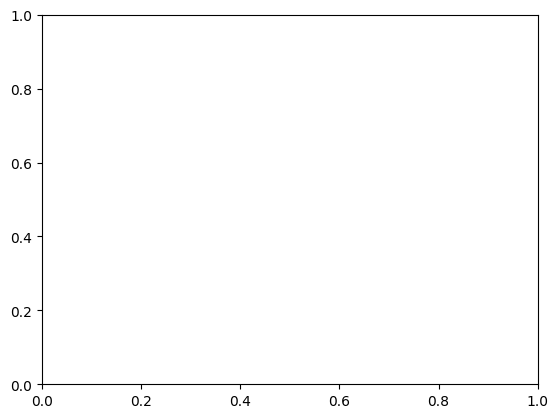

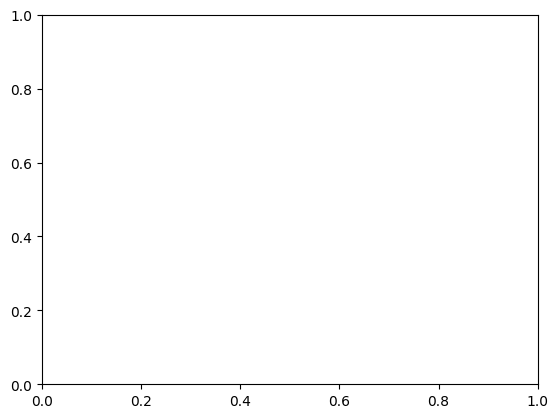

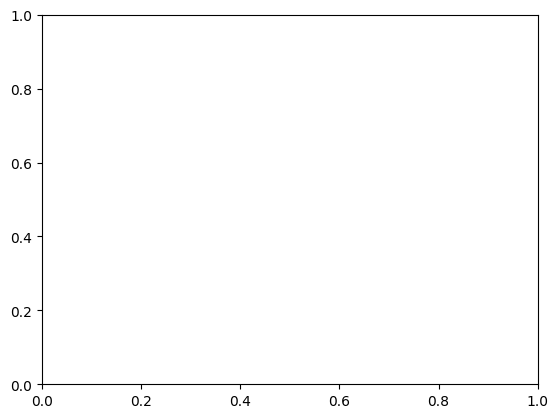

In [77]:
# Run on 12/12/2022 at 2332 (to find datafile)
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([5]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 2
    min_g= -2
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs = results[0]
    exact_energies = results[1]
    est_energies = results[2]
    exact_corrs = results[3]
    est_corrs = results[4]

In [74]:
# run without meas error mitigation on 12/12/22 at 2317

backend = provider.get_backend("ibm_oslo")

shots = 2048
max_iters = 100
loop_iters = 21
max_g = 2
min_g= -2
rot_blocks = 2
num_qubits = 5

optimizer = SPSA(maxiter=max_iters)

results_q = run_sim(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = rot_blocks,
                  shots = shots, loop_iters = loop_iters, verbose = True, quantum = True, minimize_circ = True)
    
gs_q = results_q[0]
exact_energies_q = results_q[1]
est_energies_q = results_q[2]
exact_corrs_q = results_q[3]
est_corrs_q = results_q[4]

Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -5.000+0.000j, Estimate Energy: -2.867+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.369+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -5.000+0.000j, Estimate Energy: -1.581+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.226+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -5.001+0.000j, Estimate Energy: -2.842+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.506+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -5.002+0.000j, Estimate Energy: -2.356+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.321+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -5.005+0.000j, Estimate Energy: -2.287+0.000j
Exact Correlation: 0.999+0.000j, Estimate Correlation: 0.328+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -5.013+0.000j, Estimate Energy: -1.966+0.000j
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.3

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


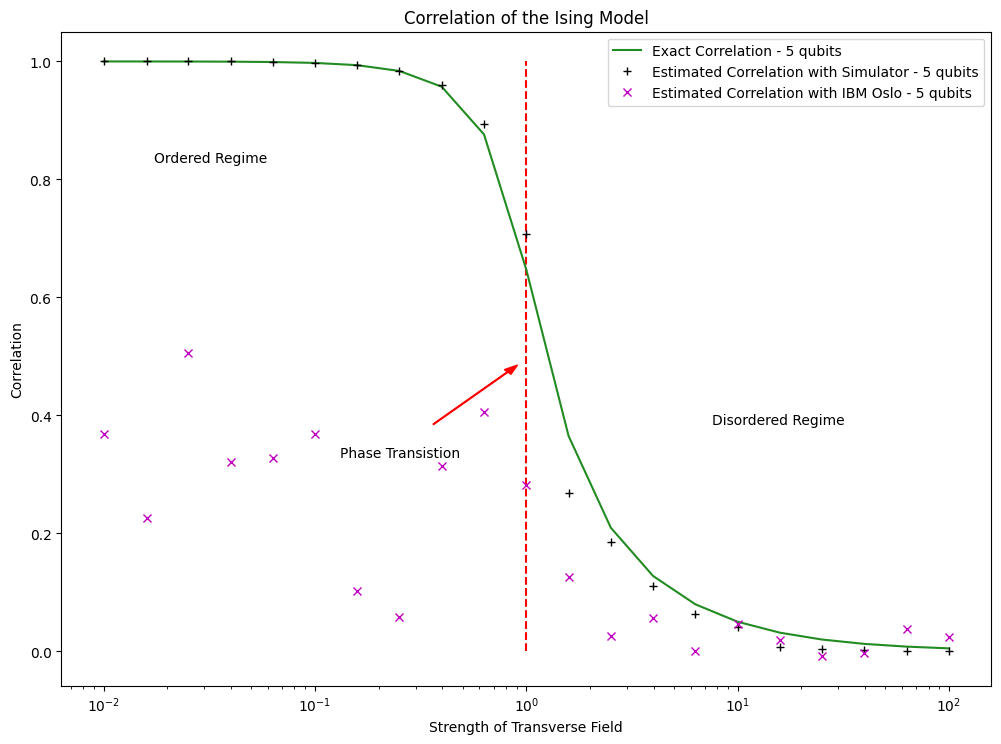

In [78]:
# finished 12/12/2022 at 2322

d_text_coords = (0.7,0.4)
o_text_coords = (0.1,0.8)
arr_coords = (0.4, 0.4, 0.08, 0.08)
lab_coords = (0.3, 0.35)

fig_c_q, ax_c_q = plot_correlations(num_qubits,gs,exact_corrs, est_corrs,
                  quantum = True, 
                  gs_q = gs_q, exact_corrs_q = exact_corrs_q, est_corrs_q = est_corrs_q)


fig_c_q, ax_c_q = write_text(fig_c_q,ax_c_q, o_text_coords,d_text_coords, arr_coords, lab_coords)


fig_c_q.savefig(os.path.join(os.getcwd(), "images", "Correlation_5_qubits_quantum2.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


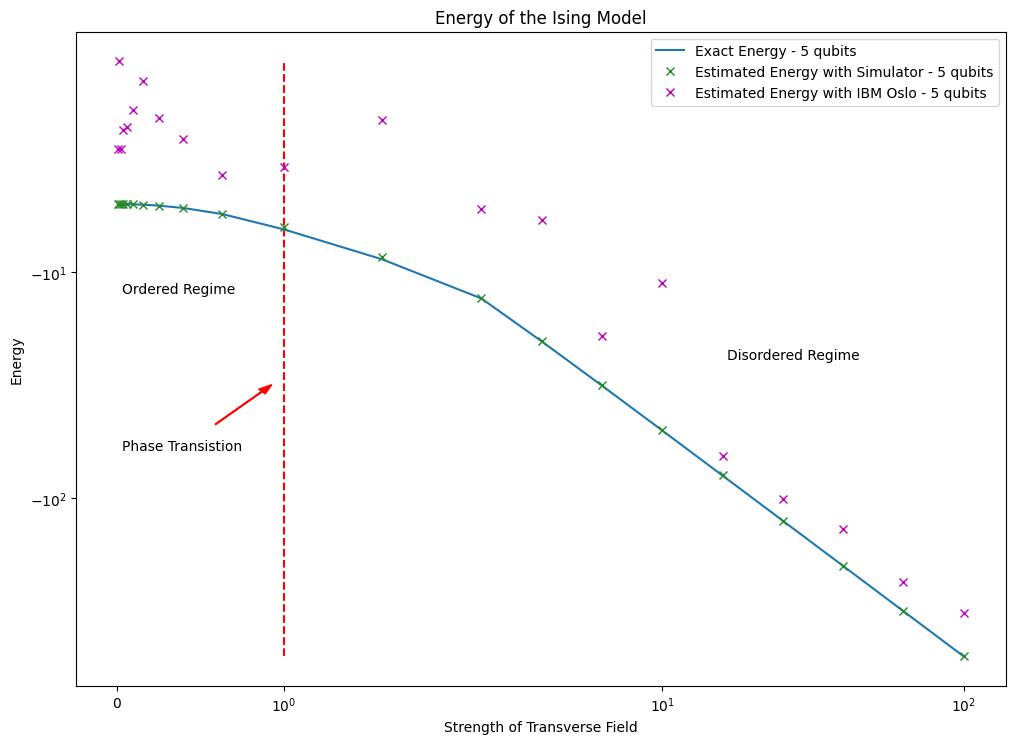

In [79]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.05,0.6)
arr_coords = (0.15, 0.4, 0.05, 0.05)
lab_coords = (0.05, 0.36)

fig_e_q, ax_e_q = plot_energies(num_qubits,gs,exact_energies, est_energies,
                  quantum = True, 
                  gs_q = gs_q, exact_energies_q = exact_energies_q, est_energies_q = est_energies_q)

fig_e_q, ax_e_q = write_text(fig_e_q,ax_e_q, o_text_coords,d_text_coords, arr_coords, lab_coords)

fig_e_q.savefig(os.path.join(os.getcwd(), "images", "Energy_5_qubits_quantum2.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


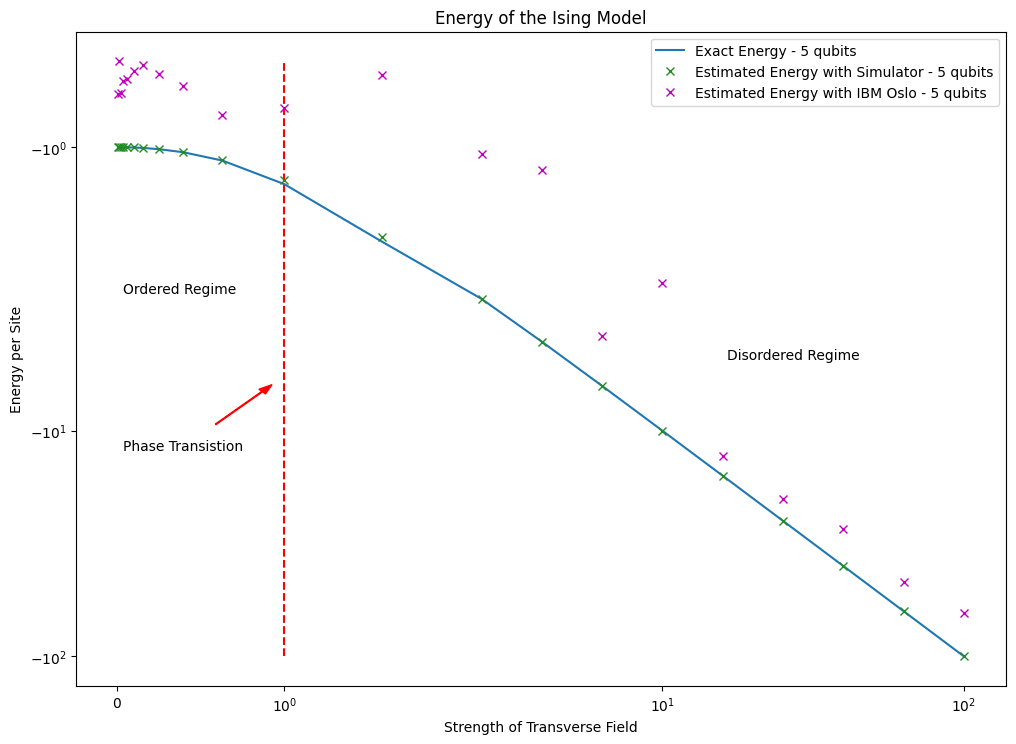

In [80]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.05,0.6)
arr_coords = (0.15, 0.4, 0.05, 0.05)
lab_coords = (0.05, 0.36)

fig_e_q_s, ax_e_q_s = plot_energies(num_qubits,gs,np.array(exact_energies)/num_qubits, 
              np.array(est_energies)/num_qubits, quantum = True, gs_q = gs_q, 
              exact_energies_q = np.array(exact_energies_q)/num_qubits, 
              est_energies_q = np.array(est_energies_q)/num_qubits, per_site = True)
    

fig_e_q_s, ax_e_q_s = write_text(fig_e_q_s,ax_e_q_s, o_text_coords,d_text_coords, arr_coords, lab_coords)


fig_e_q_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_5_qubits_quantum2.jpg"))

In [ ]:
err_eng_q = np.divide(np.abs(exact_energies-est_energies_q), exact_energies)
err_corr_q = np.divide(np.abs(exact_corrs-est_corrs_q), exact_corrs)

fige, axe = plt.subplots()
axe.plot(gs_q, err_corr_q)

### Classical Simulation results with varying number of spin particles

 
Model with 3 qubits
Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -3.000+0.000j, Estimate Energy: -3.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -3.000+0.000j, Estimate Energy: -3.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -3.000+0.000j, Estimate Energy: -3.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -3.001+0.000j, Estimate Energy: -3.001
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -3.003+0.000j, Estimate Energy: -3.003
Exact Correlation: 0.999+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -3.008+0.000j, Estimate Energy: -3.008
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.998+0.000j
Running Is

Exact Energy: -7.280-0.000j, Estimate Energy: -7.279
Exact Correlation: 0.959-0.000j, Estimate Correlation: 0.960+0.000j
Running Ising Hamiltonian with g=0.631
Exact Energy: -7.723+0.000j, Estimate Energy: -7.710
Exact Correlation: 0.886+0.000j, Estimate Correlation: 0.894+0.000j
Running Ising Hamiltonian with g=1.0
Exact Energy: -8.988+0.000j, Estimate Energy: -8.848
Exact Correlation: 0.642+0.000j, Estimate Correlation: 0.706+0.000j
Running Ising Hamiltonian with g=1.585
Exact Energy: -12.241-0.000j, Estimate Energy: -12.054
Exact Correlation: 0.345+0.000j, Estimate Correlation: 0.270-0.000j
Running Ising Hamiltonian with g=2.512
Exact Energy: -18.289-0.000j, Estimate Energy: -18.184
Exact Correlation: 0.204+0.000j, Estimate Correlation: 0.172+0.000j
Running Ising Hamiltonian with g=3.981
Exact Energy: -28.308+0.000j, Estimate Energy: -28.244
Exact Correlation: 0.127-0.000j, Estimate Correlation: 0.108-0.000j
Running Ising Hamiltonian with g=6.31
Exact Energy: -44.448-0.000j, Estimat

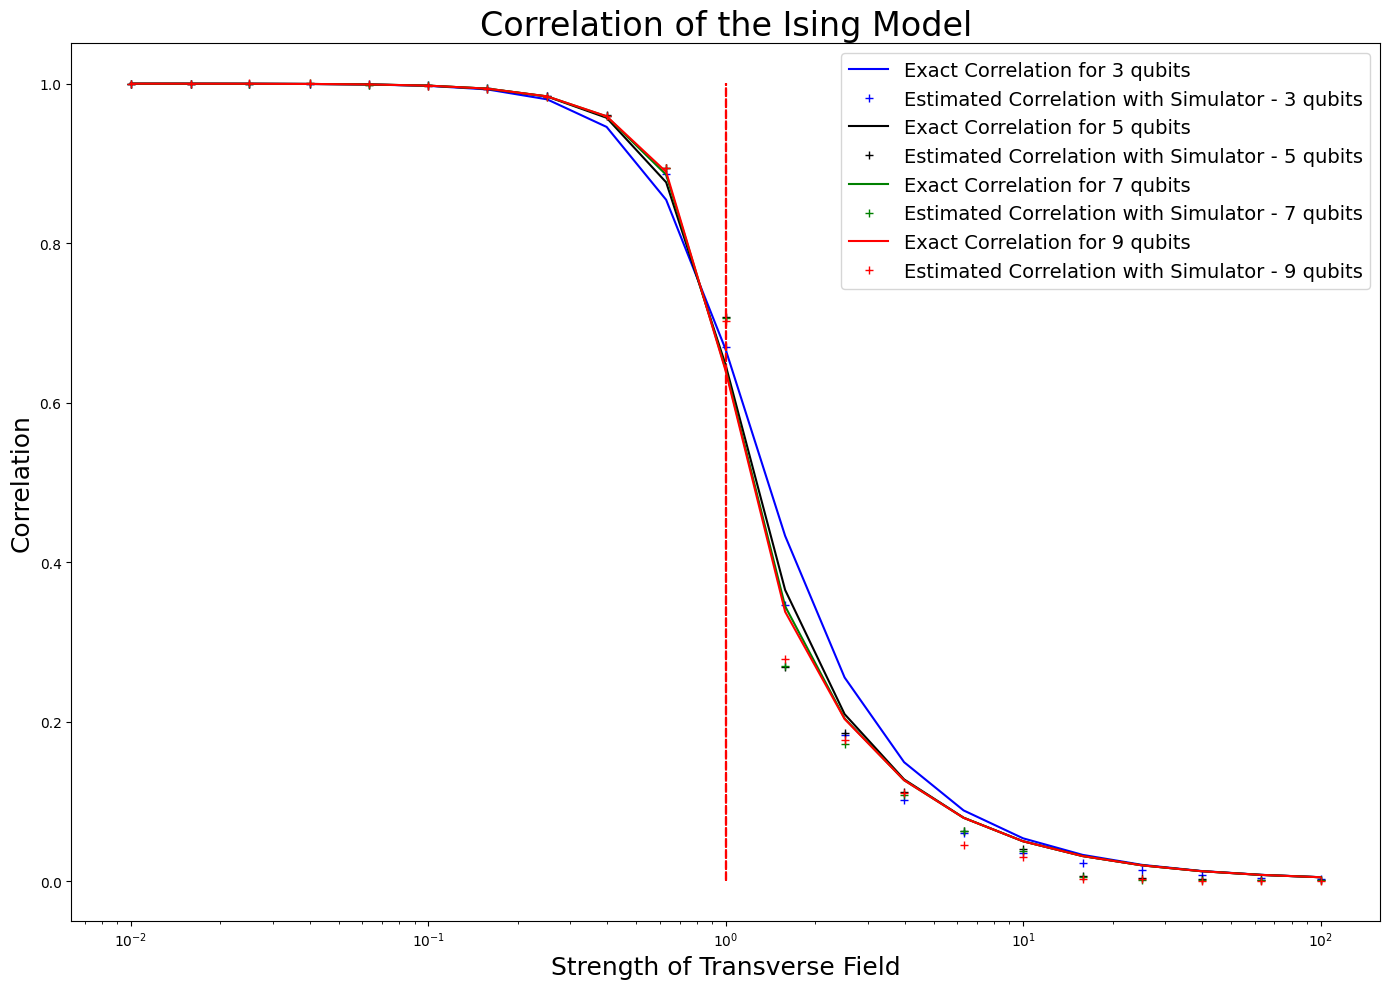

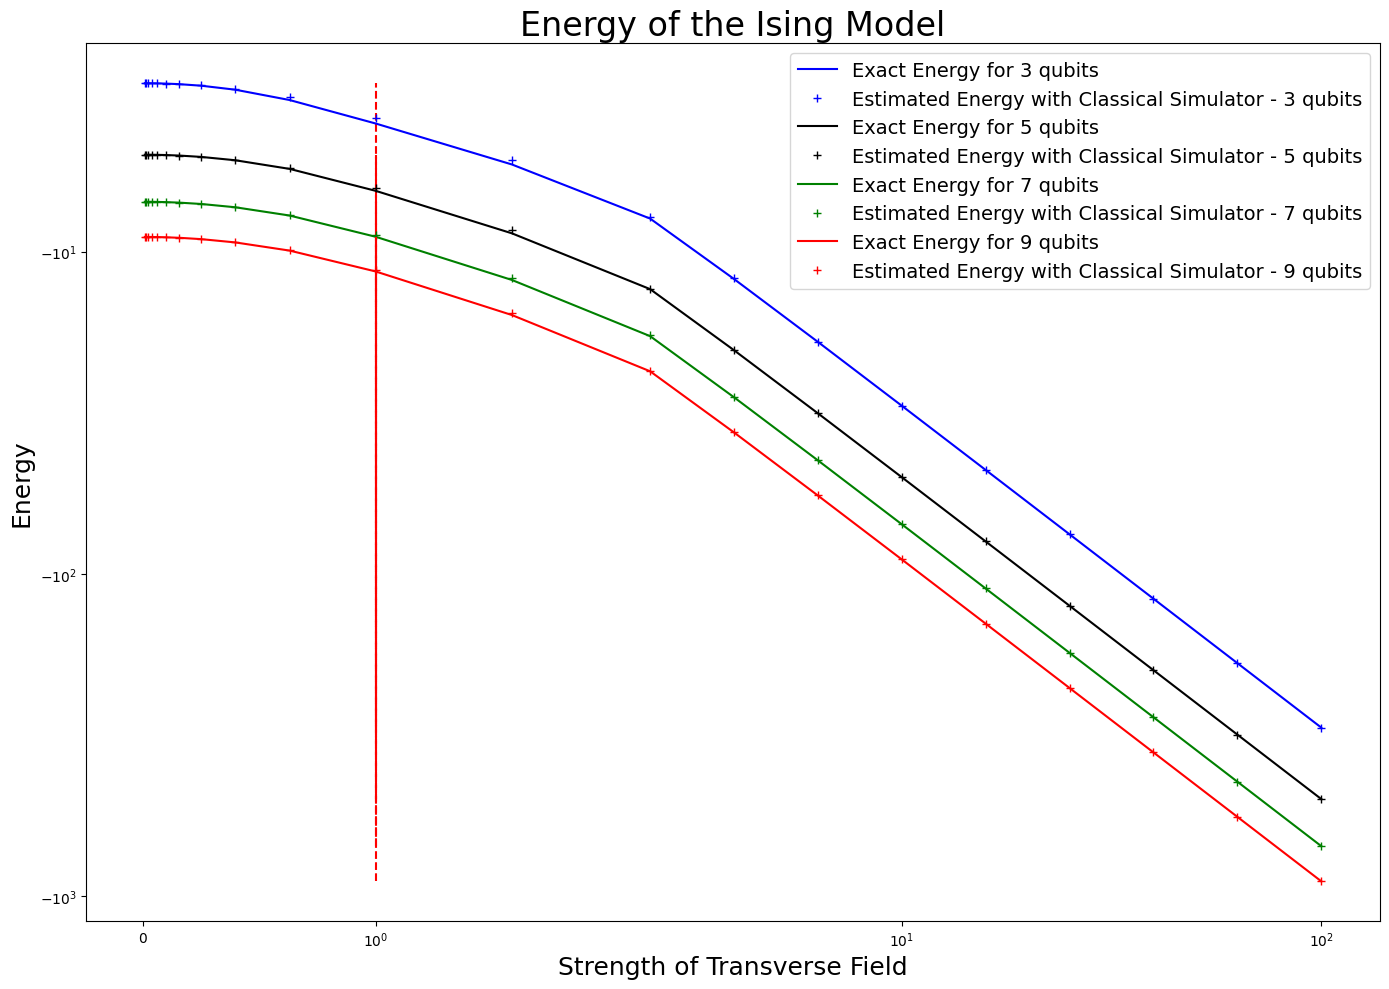

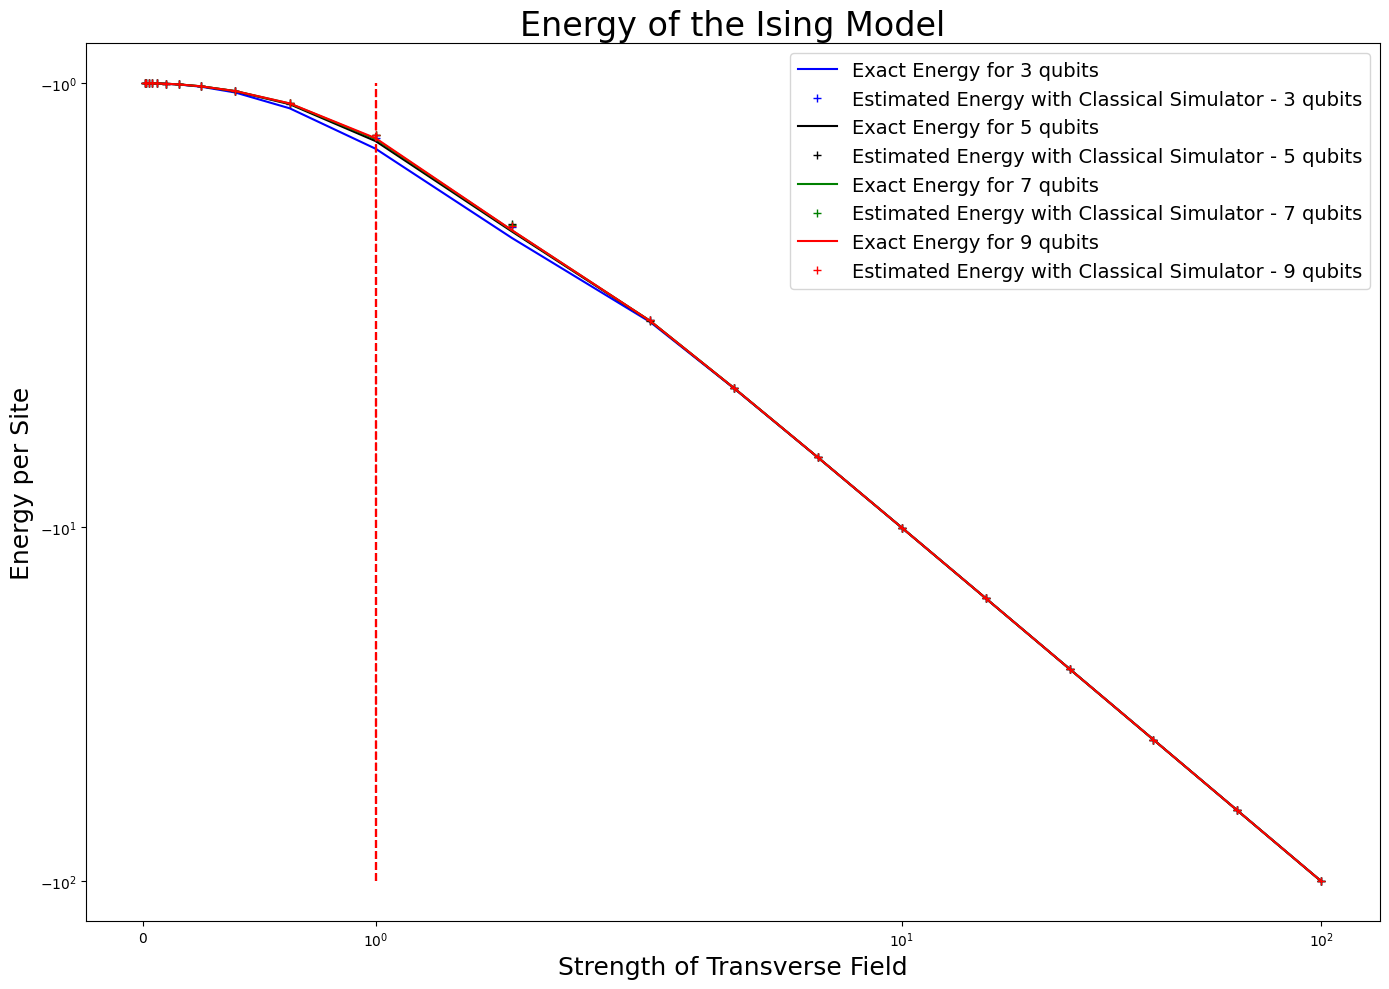

In [208]:


d_text_coords_c = (0.7,0.3)
o_text_coords_c = (0.1,0.8)
arr_coords_c = (0.4, 0.4, 0.08, 0.08)
lab_coords_c = (0.3, 0.35)

d_text_coords_e = (0.7,0.5)
o_text_coords_e = (0.05,0.6)
arr_coords_e = (0.12, 0.4, 0.08, 0.08)
lab_coords_e = (0.06, 0.35)

colors = [["blue", "blue"],["black","black"], 
                            ["green", "green"], ["red","red"]]
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([3,5,7,9]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 2
    min_g= -2
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results_n = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs_n = results_n[0]
    exact_energies_n = results_n[1]
    est_energies_n = results_n[2]
    exact_corrs_n = results_n[3]
    est_corrs_n = results_n[4]
    
    fig_c_n, ax_c_n = plot_correlations(num_q,gs_n,exact_corrs_n, est_corrs_n, 
                      fig = fig1, ax = ax1, colors = colors[idx])
    
        
    fig_e_n, ax_e_n = plot_energies(num_q,gs_n,exact_energies_n, est_energies_n, 
                      fig = fig2, ax = ax2, colors = colors[idx])
    
    
    fig_e_n_s, ax_e_n_s = plot_energies(num_q,gs_n,np.array(exact_energies_n)/num_q, np.array(est_energies_n)/num_q,
                      fig = fig3, ax = ax3, colors = colors[idx], per_site = True)

In [211]:
fig_c_n, ax_c_n= write_text(fig_c_n,ax_c_n, o_text_coords_c,d_text_coords_c, arr_coords_c, lab_coords_c)
fig_e_n, ax_e_n= write_text(fig_e_n,ax_e_n, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
fig_e_n_s, ax_e_n_s= write_text(fig_e_n_s,ax_e_n_s, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
    
fig_c_n.savefig(os.path.join(os.getcwd(), "images", "Correlation_multiple_qubits2_reformat.jpg"))
fig_e_n.savefig(os.path.join(os.getcwd(), "images", "Energy_multiple_qubits_reformat.jpg"))
fig_e_n_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_multiple_qubits_reformat.jpg"))

## More closely examine phase transition region

 
Model with 3 qubits
Running VQE
Running Ising Hamiltonian with g=0.631
Exact Energy: -3.383+0.000j, Estimate Energy: -3.313
Exact Correlation: 0.854+0.000j, Estimate Correlation: 0.886+0.000j
Running Ising Hamiltonian with g=0.661
Exact Energy: -3.423+0.000j, Estimate Energy: -3.345
Exact Correlation: 0.840+0.000j, Estimate Correlation: 0.874+0.000j
Running Ising Hamiltonian with g=0.692
Exact Energy: -3.466+0.000j, Estimate Energy: -3.380
Exact Correlation: 0.825+0.000j, Estimate Correlation: 0.860+0.000j
Running Ising Hamiltonian with g=0.724
Exact Energy: -3.513+0.000j, Estimate Energy: -3.418
Exact Correlation: 0.809+0.000j, Estimate Correlation: 0.844+0.000j
Running Ising Hamiltonian with g=0.759
Exact Energy: -3.567+0.000j, Estimate Energy: -3.462
Exact Correlation: 0.791+0.000j, Estimate Correlation: 0.828+0.000j
Running Ising Hamiltonian with g=0.794
Exact Energy: -3.623+0.000j, Estimate Energy: -3.508
Exact Correlation: 0.773+0.000j, Estimate Correlation: 0.809+0.000j
Runnin

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Exact Energy: -5.534+0.000j, Estimate Energy: -5.508
Exact Correlation: 0.876+0.000j, Estimate Correlation: 0.894+0.000j
Running Ising Hamiltonian with g=0.661
Exact Energy: -5.590+0.000j, Estimate Energy: -5.558
Exact Correlation: 0.862+0.000j, Estimate Correlation: 0.883+0.000j
Running Ising Hamiltonian with g=0.692
Exact Energy: -5.652+0.000j, Estimate Energy: -5.614
Exact Correlation: 0.845-0.000j, Estimate Correlation: 0.870+0.000j
Running Ising Hamiltonian with g=0.724
Exact Energy: -5.720+0.000j, Estimate Energy: -5.673
Exact Correlation: 0.828+0.000j, Estimate Correlation: 0.857-0.000j
Running Ising Hamiltonian with g=0.759
Exact Energy: -5.799+0.000j, Estimate Energy: -5.742
Exact Correlation: 0.807+0.000j, Estimate Correlation: 0.841+0.000j
Running Ising Hamiltonian with g=0.794
Exact Energy: -5.883+0.000j, Estimate Energy: -5.815
Exact Correlation: 0.785-0.000j, Estimate Correlation: 0.826+0.000j
Running Ising Hamiltonian with g=0.832
Exact Energy: -5.979+0.000j, Estimate En

Exact Energy: -11.266-0.000j, Estimate Energy: -11.160
Exact Correlation: 0.679+0.000j, Estimate Correlation: 0.735+0.000j
Running Ising Hamiltonian with g=1.0
Exact Energy: -11.518+0.000j, Estimate Energy: -11.381
Exact Correlation: 0.640+0.000j, Estimate Correlation: 0.703+0.000j
Running Ising Hamiltonian with g=1.047
Exact Energy: -11.797-0.000j, Estimate Energy: -11.625
Exact Correlation: 0.600+0.000j, Estimate Correlation: 0.669-0.000j
Running Ising Hamiltonian with g=1.096
Exact Energy: -12.104-0.000j, Estimate Energy: -11.896
Exact Correlation: 0.561+0.000j, Estimate Correlation: 0.628+0.000j
Running Ising Hamiltonian with g=1.148
Exact Energy: -12.447+0.000j, Estimate Energy: -12.204
Exact Correlation: 0.523-0.000j, Estimate Correlation: 0.579+0.000j
Running Ising Hamiltonian with g=1.202
Exact Energy: -12.818-0.000j, Estimate Energy: -12.549
Exact Correlation: 0.489+0.000j, Estimate Correlation: 0.517+0.000j
Running Ising Hamiltonian with g=1.259
Exact Energy: -13.224+0.000j, 

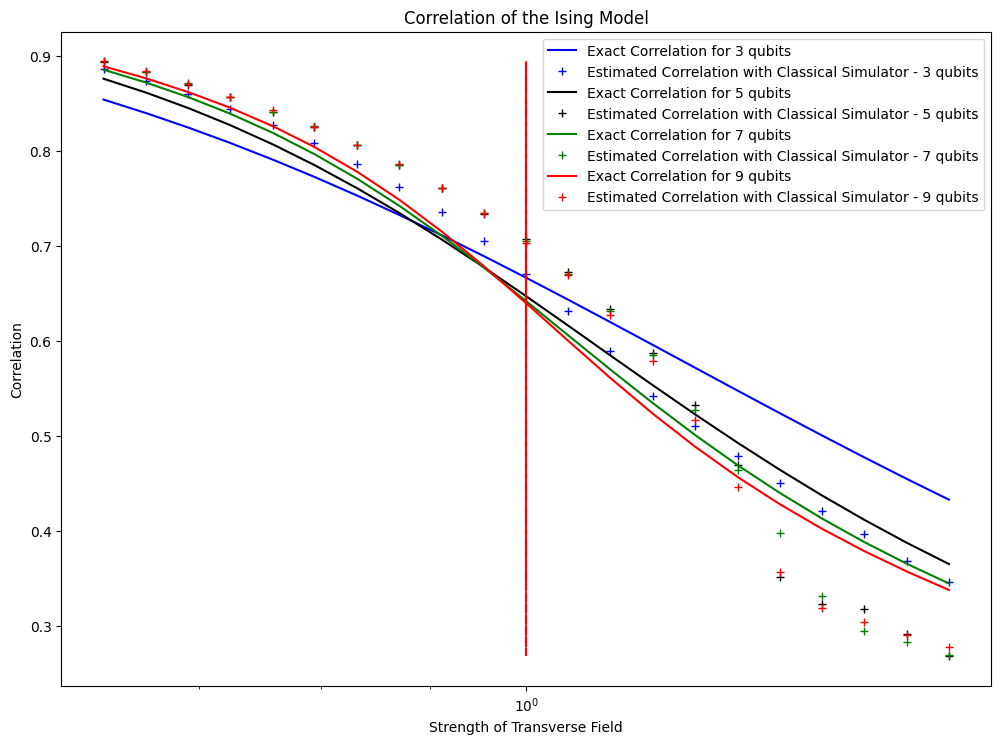

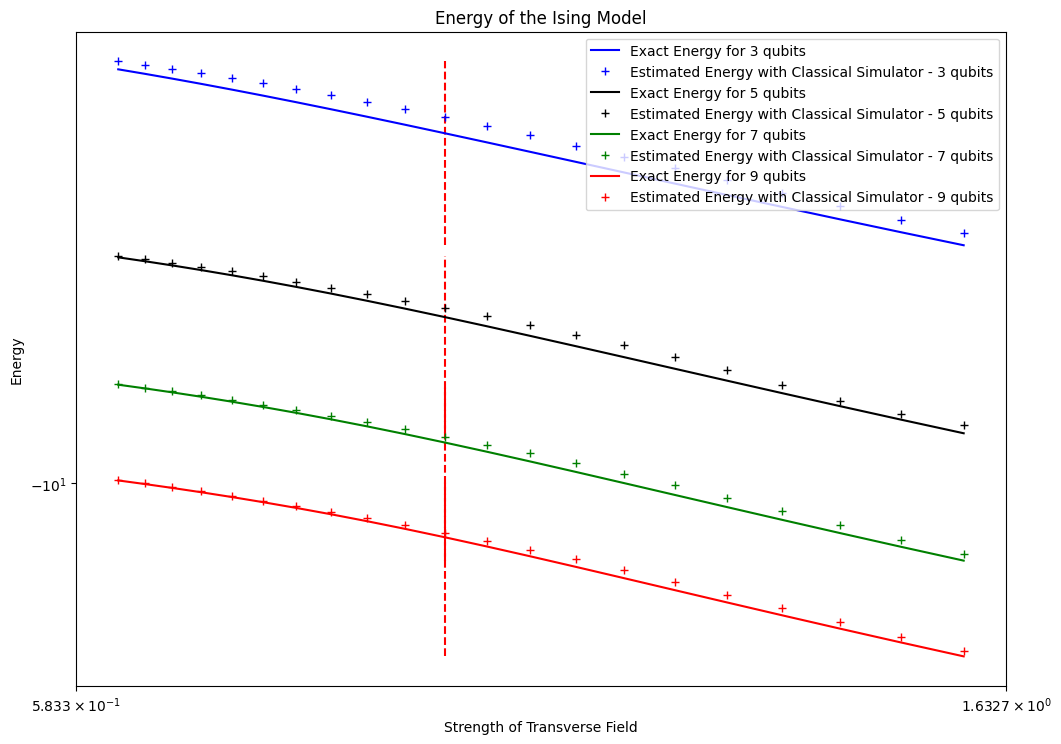

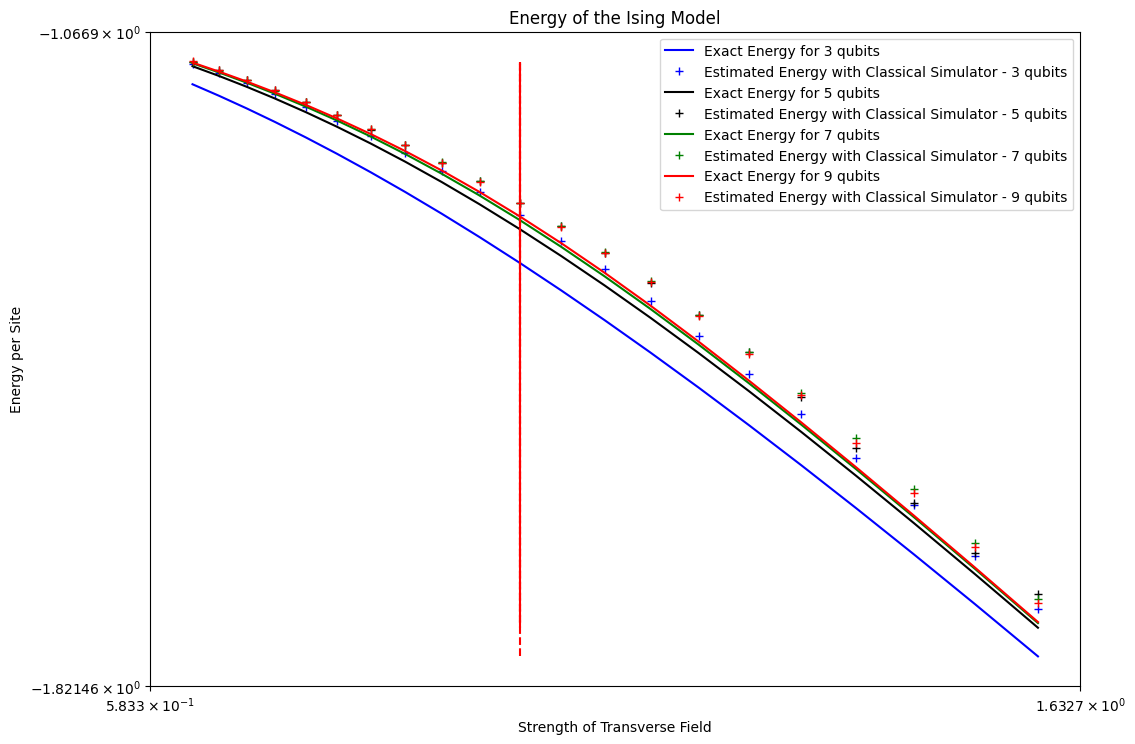

In [84]:
# Run on 12/6/2022 after above block (to find datafile)

d_text_coords_c = (0.7,0.3)
o_text_coords_c = (0.1,0.8)
arr_coords_c = (0.4, 0.4, 0.08, 0.08)
lab_coords_c = (0.3, 0.35)

d_text_coords_e = (0.7,0.5)
o_text_coords_e = (0.05,0.6)
arr_coords_e = (0.12, 0.4, 0.08, 0.08)
lab_coords_e = (0.06, 0.35)

colors = [["blue", "blue"],["black","black"], 
                            ["green", "green"], ["red","red"]]
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([3,5,7,9]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 0.2
    min_g= -0.2
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results_n = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs_n = results_n[0]
    exact_energies_n = results_n[1]
    est_energies_n = results_n[2]
    exact_corrs_n = results_n[3]
    est_corrs_n = results_n[4]
    
    fig_c_n, ax_c_n = plot_correlations(num_q,gs_n,exact_corrs_n, est_corrs_n,
                      fig = fig1, ax = ax1, colors = colors[idx])
    
        
    fig_e_n, ax_e_n = plot_energies(num_q,gs_n,exact_energies_n, est_energies_n,
                      fig = fig2, ax = ax2, colors = colors[idx])
    
    
    fig_e_n_s, ax_e_n_s = plot_energies(num_q,gs_n,np.array(exact_energies_n)/num_q, np.array(est_energies_n)/num_q,
                      fig = fig3, ax = ax3, colors = colors[idx], per_site = True)

In [85]:
fig_c_n, ax_c_n= write_text(fig_c_n,ax_c_n, o_text_coords_c,d_text_coords_c, arr_coords_c, lab_coords_c)
fig_e_n, ax_e_n= write_text(fig_e_n,ax_e_n, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
fig_e_n_s, ax_e_n_s= write_text(fig_e_n_s,ax_e_n_s, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)

fig_c_n.savefig(os.path.join(os.getcwd(), "images", "Correlation_multiple_qubits_phase_region2.jpg"))
fig_e_n.savefig(os.path.join(os.getcwd(), "images", "Energy_multiple_qubits_phase_region2.jpg"))
fig_e_n_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_multiple_qubits_phase_region2.jpg"))

 
Model with 3 qubits
Running VQE
Running Ising Hamiltonian with g=1.259
Exact Energy: -4.562+0.000j, Estimate Energy: -4.384
Exact Correlation: 0.548+0.000j, Estimate Correlation: 0.479+0.000j
Running Ising Hamiltonian with g=1.318
Exact Energy: -4.701+0.000j, Estimate Energy: -4.524
Exact Correlation: 0.524+0.000j, Estimate Correlation: 0.450+0.000j
Running Ising Hamiltonian with g=1.38
Exact Energy: -4.849+0.000j, Estimate Energy: -4.675
Exact Correlation: 0.501+0.000j, Estimate Correlation: 0.422+0.000j
Running Ising Hamiltonian with g=1.445
Exact Energy: -5.009+0.000j, Estimate Energy: -4.838
Exact Correlation: 0.478+0.000j, Estimate Correlation: 0.396+0.000j
Running Ising Hamiltonian with g=1.514
Exact Energy: -5.181+0.000j, Estimate Energy: -5.014
Exact Correlation: 0.455+0.000j, Estimate Correlation: 0.369+0.000j
Running Ising Hamiltonian with g=1.585
Exact Energy: -5.361+0.000j, Estimate Energy: -5.199
Exact Correlation: 0.433+0.000j, Estimate Correlation: 0.346+0.000j
Running

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Exact Energy: -7.407+0.000j, Estimate Energy: -7.182
Exact Correlation: 0.493+0.000j, Estimate Correlation: 0.463+0.000j
Running Ising Hamiltonian with g=1.318
Exact Energy: -7.642+0.000j, Estimate Energy: -7.439
Exact Correlation: 0.465+0.000j, Estimate Correlation: 0.350+0.000j
Running Ising Hamiltonian with g=1.38
Exact Energy: -7.896+0.000j, Estimate Energy: -7.732
Exact Correlation: 0.438+0.000j, Estimate Correlation: 0.323+0.000j
Running Ising Hamiltonian with g=1.445
Exact Energy: -8.168+0.000j, Estimate Energy: -8.051
Exact Correlation: 0.412+0.000j, Estimate Correlation: 0.318-0.000j
Running Ising Hamiltonian with g=1.514
Exact Energy: -8.462-0.000j, Estimate Energy: -8.337
Exact Correlation: 0.388-0.000j, Estimate Correlation: 0.291+0.000j
Running Ising Hamiltonian with g=1.585
Exact Energy: -8.771+0.000j, Estimate Energy: -8.578
Exact Correlation: 0.365+0.000j, Estimate Correlation: 0.268+0.000j
Running Ising Hamiltonian with g=1.66
Exact Energy: -9.102+0.000j, Estimate Ener

Exact Energy: -17.643+0.000j, Estimate Energy: -17.481
Exact Correlation: 0.288+0.000j, Estimate Correlation: 0.244+0.000j
Running Ising Hamiltonian with g=1.905
Exact Energy: -18.349-0.000j, Estimate Energy: -18.197
Exact Correlation: 0.274+0.000j, Estimate Correlation: 0.233-0.000j
Running Ising Hamiltonian with g=1.995
Exact Energy: -19.102+0.000j, Estimate Energy: -18.960
Exact Correlation: 0.260+0.000j, Estimate Correlation: 0.223+0.000j
Running Ising Hamiltonian with g=2.089
Exact Energy: -19.895+0.000j, Estimate Energy: -19.761
Exact Correlation: 0.247+0.000j, Estimate Correlation: 0.212+0.000j
Running Ising Hamiltonian with g=2.188
Exact Energy: -20.735-0.000j, Estimate Energy: -20.608
Exact Correlation: 0.235+0.000j, Estimate Correlation: 0.204+0.000j
Running Ising Hamiltonian with g=2.291
Exact Energy: -21.614-0.000j, Estimate Energy: -21.494
Exact Correlation: 0.224+0.000j, Estimate Correlation: 0.194+0.000j
Running Ising Hamiltonian with g=2.399
Exact Energy: -22.540-0.000j

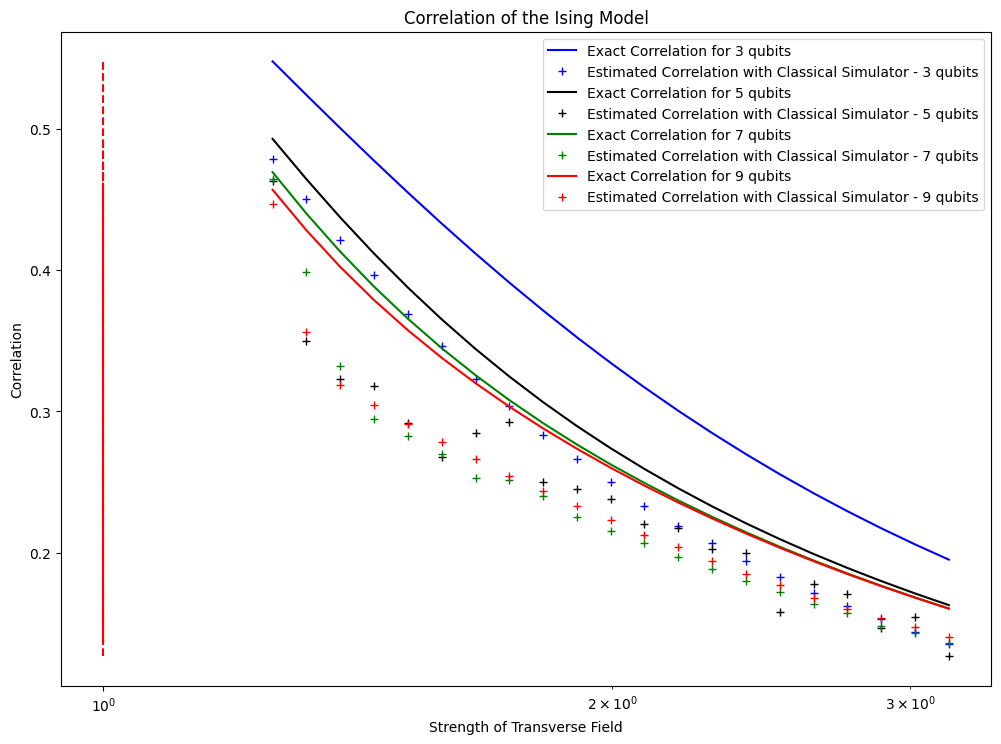

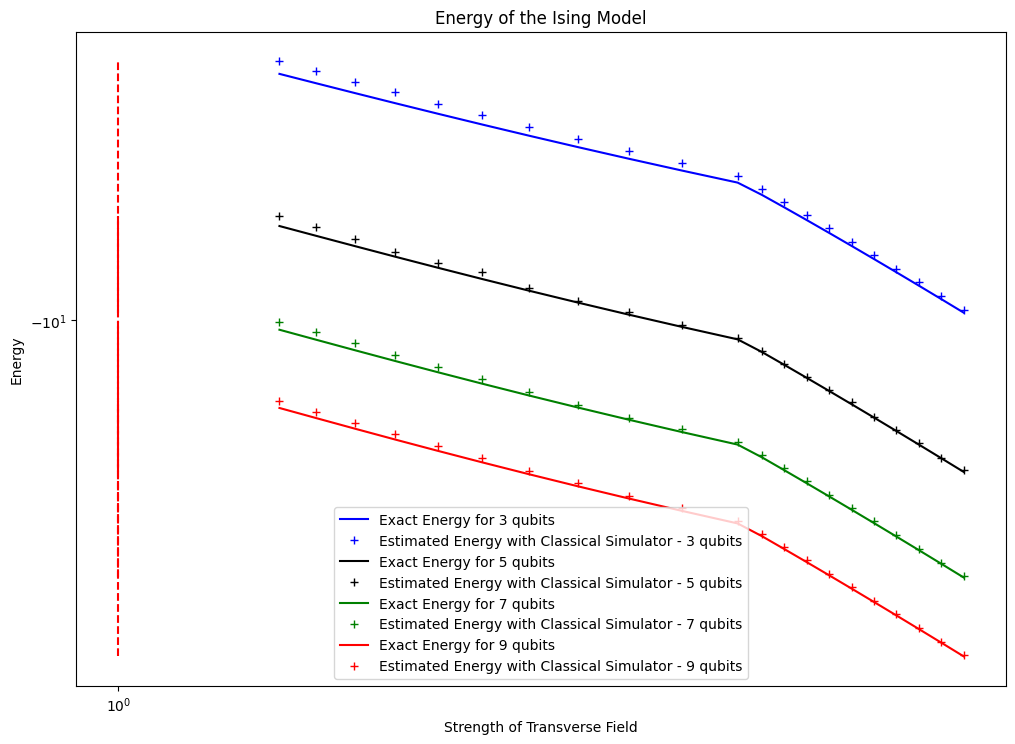

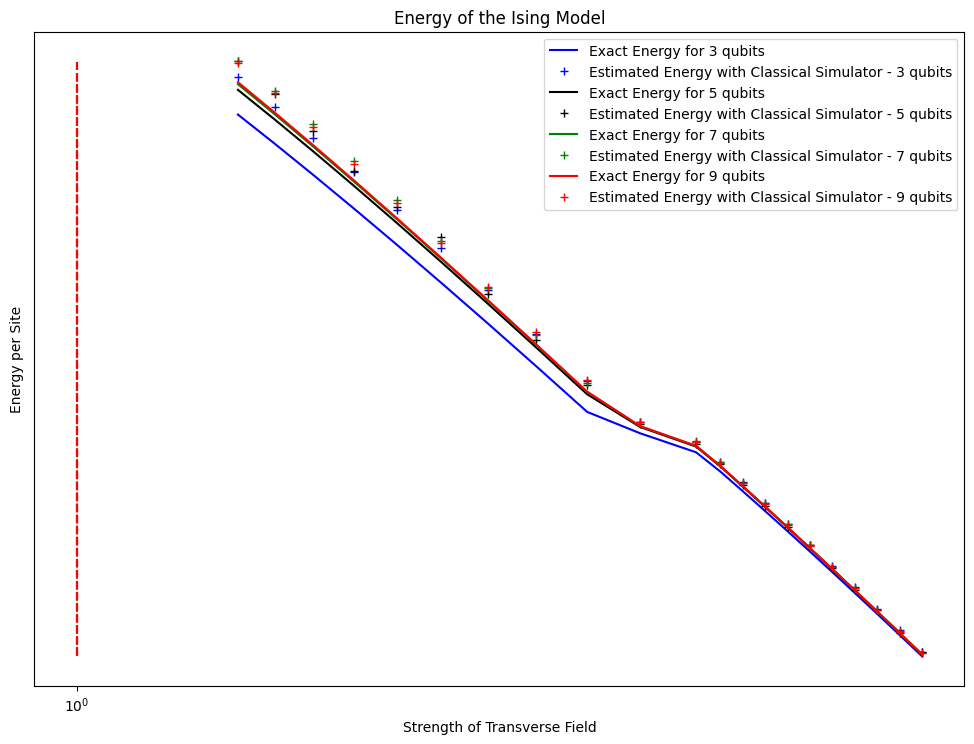

In [88]:
# Run on 12/6/2022 after above block (to find datafile)

d_text_coords_c = (0.7,0.3)
o_text_coords_c = (0.1,0.8)
arr_coords_c = (0.4, 0.4, 0.08, 0.08)
lab_coords_c = (0.3, 0.35)

d_text_coords_e = (0.7,0.5)
o_text_coords_e = (0.05,0.6)
arr_coords_e = (0.12, 0.4, 0.08, 0.08)
lab_coords_e = (0.06, 0.35)

colors = [["blue", "blue"],["black","black"], 
                            ["green", "green"], ["red","red"]]
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([3,5,7,9]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 0.5
    min_g= 0.1
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results_n = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs_n = results_n[0]
    exact_energies_n = results_n[1]
    est_energies_n = results_n[2]
    exact_corrs_n = results_n[3]
    est_corrs_n = results_n[4]
    
    fig_c_n, ax_c_n = plot_correlations(num_q,gs_n,exact_corrs_n, est_corrs_n,
                      fig = fig1, ax = ax1, colors = colors[idx])
    
        
    fig_e_n, ax_e_n = plot_energies(num_q,gs_n,exact_energies_n, est_energies_n,
                      fig = fig2, ax = ax2, colors = colors[idx])
    
    
    fig_e_n_s, ax_e_n_s = plot_energies(num_q,gs_n,np.array(exact_energies_n)/num_q, np.array(est_energies_n)/num_q,
                      fig = fig3, ax = ax3, colors = colors[idx], per_site = True)

In [89]:
fig_c_n, ax_c_n= write_text(fig_c_n,ax_c_n, o_text_coords_c,d_text_coords_c, arr_coords_c, lab_coords_c)
fig_e_n, ax_e_n= write_text(fig_e_n,ax_e_n, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
fig_e_n_s, ax_e_n_s= write_text(fig_e_n_s,ax_e_n_s, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)

fig_c_n.savefig(os.path.join(os.getcwd(), "images", "Correlation_multiple_qubits_large_g_102.jpg"))
fig_e_n.savefig(os.path.join(os.getcwd(), "images", "Energy_multiple_qubits_large_g_102.jpg"))
fig_e_n_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_multiple_qubits_large_g_102.jpg"))

In [83]:
backend = Aer.get_backend('statevector_simulator')

shots = 2048
max_iters = 100
loop_iters = 21
max_g = 2
min_g= -2
rot_blocks = 2
num_qubits = 3

optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

results_f = run_sim_frustration(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = rot_blocks,
                  shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)
    
gs_f = results_f[0]
exact_energies_f = results_f[1]
est_energies_f = results_f[2]
exact_corrs_f = results_f[3]
est_corrs_f = results_f[4]

Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -1.020+0.000j, Estimate Energy: -1.005
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.333+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -1.032+0.000j, Estimate Energy: -1.009
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.332+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -1.050+0.000j, Estimate Energy: -1.011
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.332+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -1.081+0.000j, Estimate Energy: -1.033
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.329+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -1.129+0.000j, Estimate Energy: -1.061
Exact Correlation: -0.332+0.000j, Estimate Correlation: -0.326+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -1.207+0.000j, Estimate Energy: -1.207
Exact Correlation: -0.331+0.000j, Estimate Correlation: -0.331+0.000j
Running Ising Hamilt

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


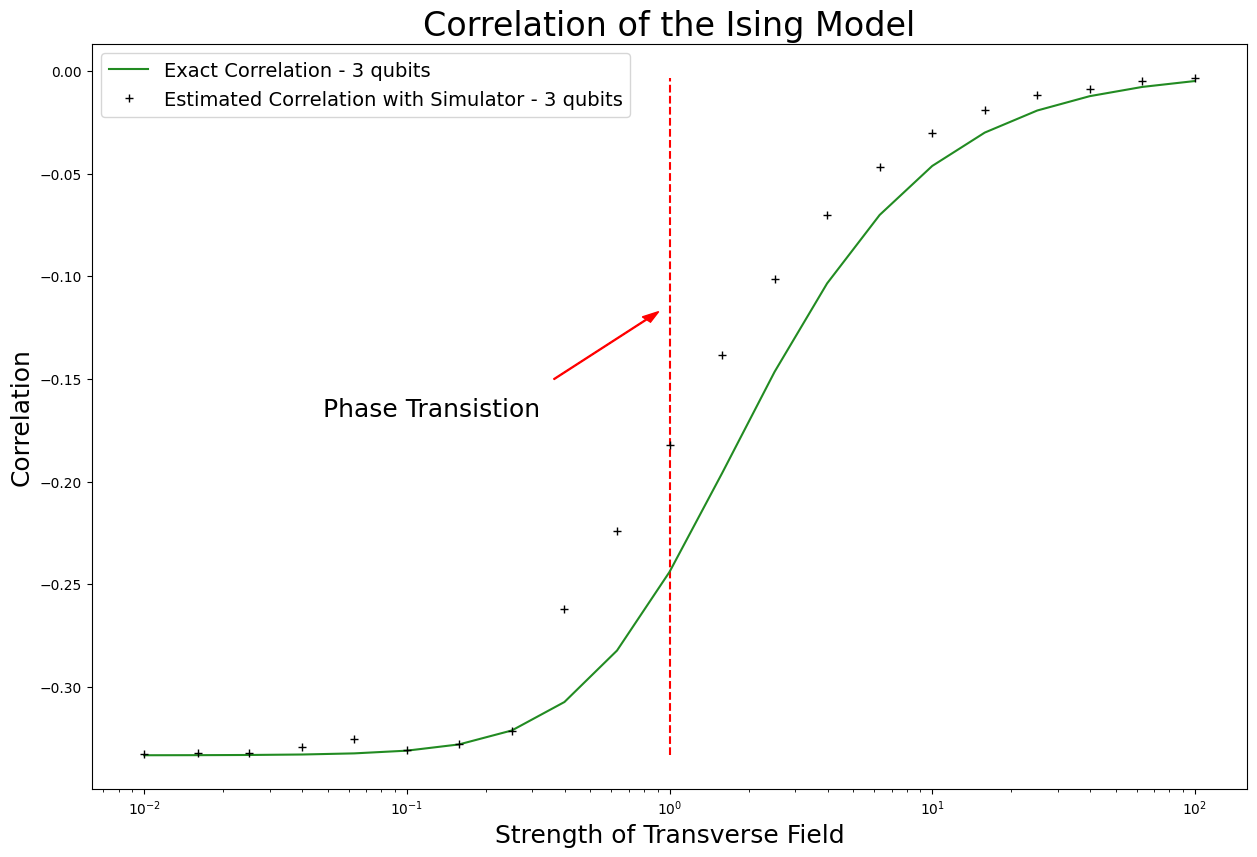

In [264]:
# finished 12/6/2022 at 2013

d_text_coords = (0.7,0.4)
o_text_coords = (0.1,0.8)
arr_coords = (0.4, 0.55, 0.08, 0.08)
lab_coords = (0.2, 0.5)

fig_c_f, ax_c_f = plot_correlations(3,gs_f,exact_corrs_f, est_corrs_f,
                  quantum = False)


fig_c_f, ax_c_f = write_text_frust(fig_c_f,ax_c_f, arr_coords, lab_coords)


fig_c_f.savefig(os.path.join(os.getcwd(), "images", "Correlation_3_qubits_frusturation4.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


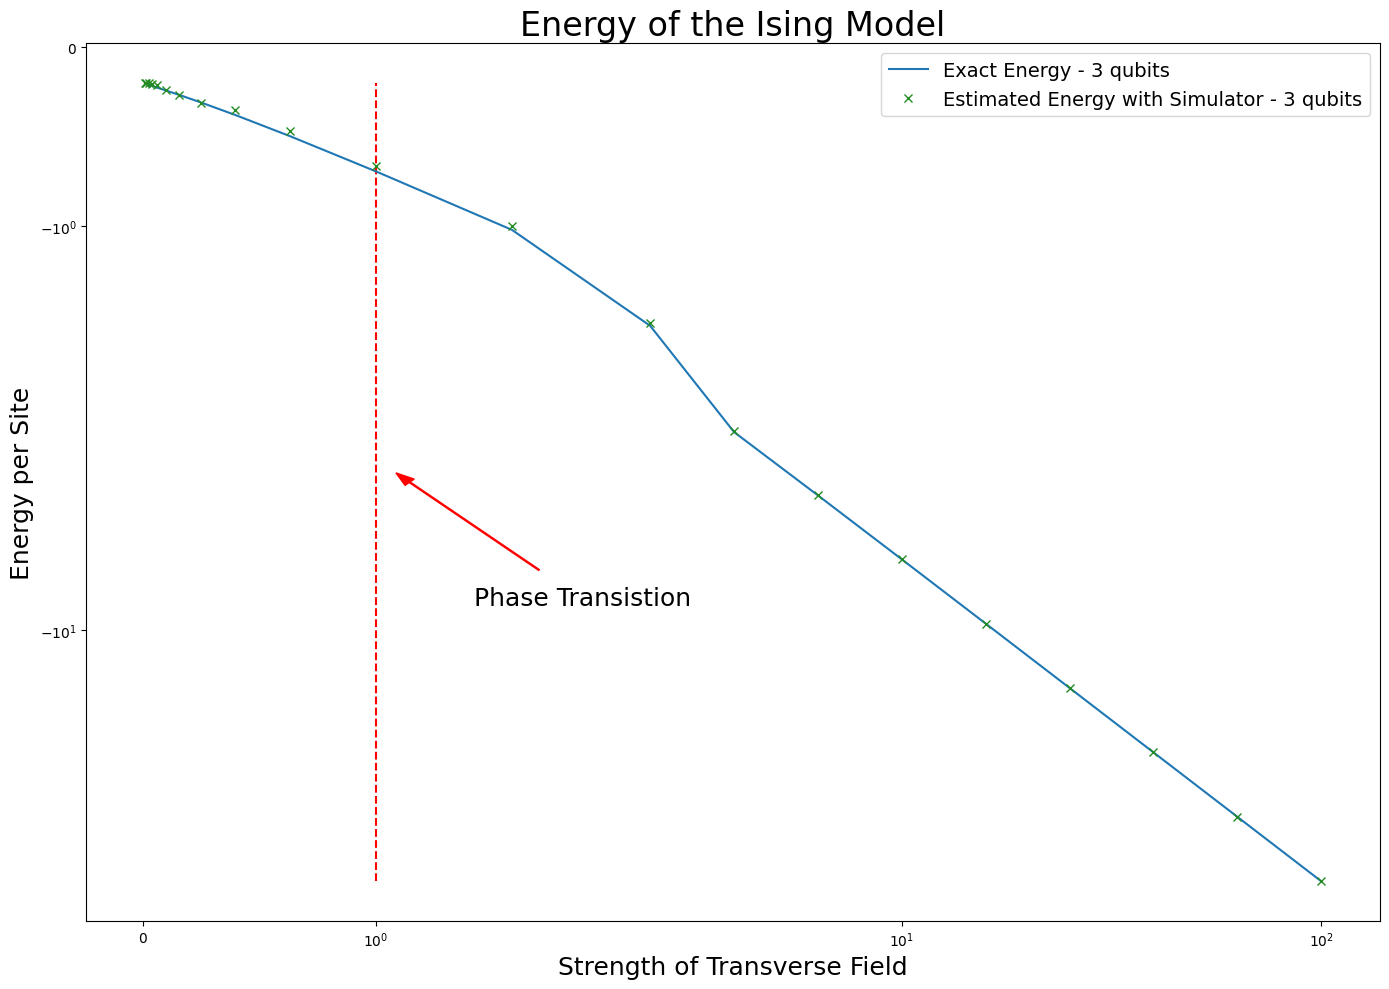

In [265]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.05,0.6)
arr_coords = (0.35, 0.4, -0.1, 0.1)
lab_coords = (0.30, 0.36)

fig_e_f_s, ax_e_f_s = plot_energies(3,gs_f,np.array(exact_energies_f)/num_qubits, 
              np.array(est_energies_f)/num_qubits, per_site = True)
    

fig_e_f_s, ax_e_f_s = write_text_frust(fig_e_f_s,ax_e_f_s, arr_coords, lab_coords)


fig_e_f_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_3_qubits_frusturation4.jpg"))

### Load Data from IBM Oslo to get experimental error

In [8]:
quantum_data = pd.read_csv(os.path.join(os.getcwd(), "data","12_12_2022","23_17_14", "Sim_Results_5_quantum.csv"))

In [9]:
quantum_data

Unnamed: 0       gs                                 Exact Energies  \
0            0    0.010                         (-5.00012500080861+0j)   
1            1    0.016                        (-5.000320005407018+0j)   
2            2    0.025                         (-5.00078128319202+0j)   
3            3    0.040                        (-5.002000228063251+0j)   
4            4    0.063                       (-5.0049627528881935+0j)   
5            5    0.100                        (-5.012510556199557+0j)   
6            6    0.158                        (-5.031280664514634+0j)   
7            7    0.251                        (-5.079332151203975+0j)   
8            8    0.398                        (-5.202602682749281+0j)   
9            9    0.631                        (-5.533729542213835+0j)   
10          10    1.000    (-6.472135954999599+2.245673160700876e-63j)   
11          11    1.585                        (-8.770714806669012+0j)   
12          12    2.512                        (-13.06917251820402+0j)   
13          13    3.981                       (-20.221311960746544+0j)   
14          14    6.310                        (-31.74858202914698+0j)   
15          15   10.000                        (-50.12510556199569+0j)   
16          16   15.849                         (-79.3238932998581+0j)   
17          17   25.119  (-125.64476874516238-1.3811942604030967e-30j)   
18          18   39.811                         (-199.086399704433+0j)   
19          19   63.096                        (-315.4998114098146+0j)   
20          20  100.000                       (-500.01250008086106+0j)   

           Estimate Energies          Exact Correlations  \
0       (-2.866748046875+0j)     (0.9999749995093569+0j)   
1               (-1.5805+0j)     (0.9999359966983296+0j)   
2         (-2.8419921875+0j)     (0.9998437295492043+0j)   
3          (-2.356015625+0j)     (0.9995998575401001+0j)   
4   (-2.2866982421874997+0j)     (0.9990067937459879+0j)   
5   (-1.9656249999999997+0j)     (0.9974931177149436+0j)   
6        (-1.73873828125+0j)     (0.9937082460318113+0j)   
7      (-2.0787509765625+0j)     (0.9838487228053747+0j)   
8       (-2.578759765625+0j)      (0.957171668829507+0j)   
9       (-3.729826171875+0j)     (0.8762773758859539+0j)   
10  (-3.4267578125000004+0j)     (0.6472135954999588+0j)   
11   (-2.124916992187501+0j)    (0.36517961761545925+0j)   
12         (-5.272265625+0j)    (0.20947205279334036+0j)   
13     (-5.8963115234375+0j)     (0.1276627192964074+0j)   
14  (-19.105976562499983+0j)    (0.07966062364192308+0j)   
15  (-11.128906249999998+0j)    (0.05008993524967747+0j)   
16   (-65.15800781249997+0j)   (0.031567778840055086+0j)   
17  (-100.97878906250004+0j)   (0.019909883027684556+0j)   
18  (-136.68437402343747+0j)   (0.012560442485018848+0j)   
19  (-234.10247656250004+0j)    (0.00792469869807924+0j)   
20        (-322.26953125+0j)  (0.0050000652365750275+0j)   

                  Estimate Corr  
0                  (0.36875+0j)  
1      (0.22578125000000002+0j)  
2       (0.5058593749999999+0j)  
3      (0.32109374999999996+0j)  
4              (0.327734375+0j)  
5      (0.36835937500000004+0j)  
6      (0.10195312500000005+0j)  
7      (0.05898437500000001+0j)  
8      (0.31367187500000004+0j)  
9              (0.405078125+0j)  
10              (0.28203125+0j)  
11               (0.1265625+0j)  
12             (0.026171875+0j)  
13     (0.05585937499999999+0j)  
14                           0j  
15     (0.04648437500000001+0j)  
16    (0.018750000000000003+0j)  
17   (-0.008593750000000015+0j)  
18  (-0.0027343750000000003+0j)  
19    (0.037500000000000006+0j)  
20    (0.025000000000000012+0j)

In [46]:
gs = quantum_data["gs"]

In [14]:
exact_energies = quantum_data["Exact Energies"]

In [15]:
est_energies = quantum_data["Estimate Energies"]

In [52]:
exp_errs_eng = []

for idx, ex_eng in enumerate(exact_energies): 
    
    ex_eng = eval(ex_eng) #extract complex number from string
    est_eng = eval(est_energies[idx])
    
    exp_err = abs((est_eng - ex_eng)/ ex_eng)
    exp_errs_eng.append(exp_err)
    
        
    print(f"Magnetic field Strength: {gs[idx]}, Exact Energy: {ex_eng}, \n Esimate Energy: {est_eng}, Experimental_Error: {exp_err}\n")
    
print(f"Max Experimental Error when estimating energy {max(exp_errs_eng)}")

Magnetic field Strength: 0.01, Exact Energy: (-5.00012500080861+0j), 
 Esimate Energy: (-2.866748046875+0j), Experimental_Error: 0.42666472409961836

Magnetic field Strength: 0.016, Exact Energy: (-5.000320005407018+0j), 
 Esimate Energy: (-1.5805+0j), Experimental_Error: 0.6839202294471253

Magnetic field Strength: 0.025, Exact Energy: (-5.00078128319202+0j), 
 Esimate Energy: (-2.8419921875+0j), Experimental_Error: 0.43169036465319194

Magnetic field Strength: 0.04, Exact Energy: (-5.002000228063251+0j), 
 Esimate Energy: (-2.356015625+0j), Experimental_Error: 0.5289853023632833

Magnetic field Strength: 0.063, Exact Energy: (-5.0049627528881935+0j), 
 Esimate Energy: (-2.2866982421874997+0j), Experimental_Error: 0.5431138341902896

Magnetic field Strength: 0.1, Exact Energy: (-5.012510556199557+0j), 
 Esimate Energy: (-1.9656249999999997+0j), Experimental_Error: 0.6078561874410655

Magnetic field Strength: 0.158, Exact Energy: (-5.031280664514634+0j), 
 Esimate Energy: (-1.738738281

In [33]:
exact_correlations = quantum_data["Exact Correlations"]

In [36]:
est_correlations = quantum_data["Estimate Corr"]

In [53]:
exp_errs_corr = []

for idx, ex_corr in enumerate(exact_correlations): 
    
    ex_corr = eval(ex_corr) #extract complex number from string
    est_corr = eval(est_correlations[idx])
    
    exp_err = abs((est_corr - ex_corr)/ ex_corr)
    exp_errs_corr.append(exp_err)
    
    print(f"Magnetic field Strength: {gs[idx]}, Exact Correlation: {ex_corr}, \n Esimate Correlation: {est_corr}, Experimental_Error: {exp_err}\n")
    
print(f"Max Experimental Error when Estimating Correlation {max(exp_errs_corr)}")

Magnetic field Strength: 0.01, Exact Correlation: (0.9999749995093569+0j), 
 Esimate Correlation: (0.36875+0j), Experimental_Error: 0.6312407808385918

Magnetic field Strength: 0.016, Exact Correlation: (0.9999359966983296+0j), 
 Esimate Correlation: (0.22578125000000002+0j), Experimental_Error: 0.77420429832959

Magnetic field Strength: 0.025, Exact Correlation: (0.9998437295492043+0j), 
 Esimate Correlation: (0.5058593749999999+0j), Experimental_Error: 0.49406156177218336

Magnetic field Strength: 0.04, Exact Correlation: (0.9995998575401001+0j), 
 Esimate Correlation: (0.32109374999999996+0j), Experimental_Error: 0.6787777153248354

Magnetic field Strength: 0.063, Exact Correlation: (0.9990067937459879+0j), 
 Esimate Correlation: (0.327734375+0j), Experimental_Error: 0.6719397935512625

Magnetic field Strength: 0.1, Exact Correlation: (0.9974931177149436+0j), 
 Esimate Correlation: (0.36835937500000004+0j), Experimental_Error: 0.6307148706511004

Magnetic field Strength: 0.158, Exac

## Refomat graphs using stored data for easier visibility

rerun basic 5 qubit sim code

 
Model with 5 qubits
Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -5.001+0.000j, Estimate Energy: -5.001
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -5.002+0.000j, Estimate Energy: -5.002
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -5.005+0.000j, Estimate Energy: -5.005
Exact Correlation: 0.999+0.000j, Estimate Correlation: 0.998+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -5.013+0.000j, Estimate Energy: -5.013
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.997+0.000j
Running Is

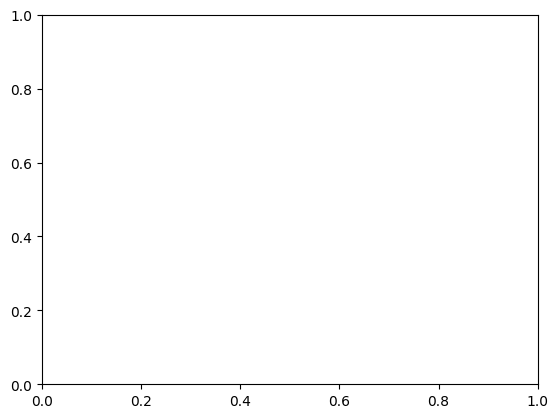

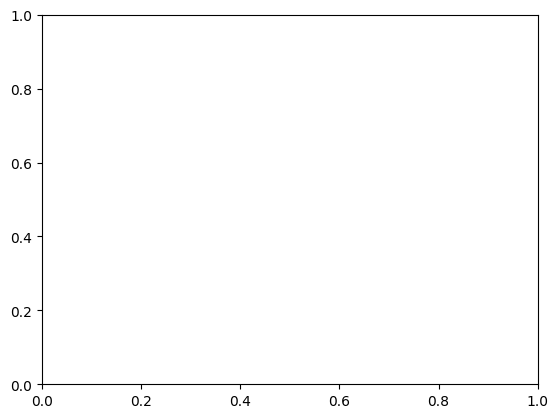

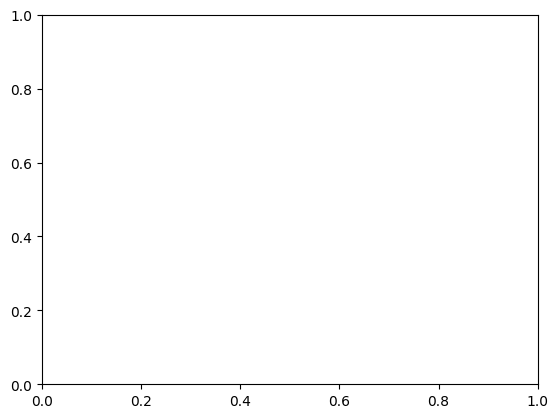

In [106]:
# Run on 12/12/2022 at 2332 (to find datafile)
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([5]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 2
    min_g= -2
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs = results[0]
    exact_energies = results[1]
    est_energies = results[2]
    exact_corrs = results[3]
    est_corrs = results[4]

load data from oslo and plot

In [125]:
exact_corrs_load_q = quantum_data["Exact Correlations"]

In [126]:
exact_corrs_q = []
for item in exact_corrs_load_q:
    exact_corrs_q.append(eval(item))

In [127]:
est_corrs_load_q = quantum_data["Estimate Corr"]

In [128]:
est_corrs_q = []
for item in est_corrs_load_q:
    est_corrs_q.append(eval(item))

In [185]:
est_energies_load_q = quantum_data["Estimate Energies"]

In [187]:
est_energies_q = []
for item in est_energies_load_q:
    est_energies_q.append(eval(item))

In [190]:
exact_energies_load_q = quantum_data["Exact Energies"]

In [191]:
exact_energies_q = []
for item in exact_energies_load_q:
    exact_energies_q.append(eval(item))

In [139]:
gs_load_q = quantum_data["gs"]
gs_q = []
for item in gs_load_q:
    gs_q.append(item)

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


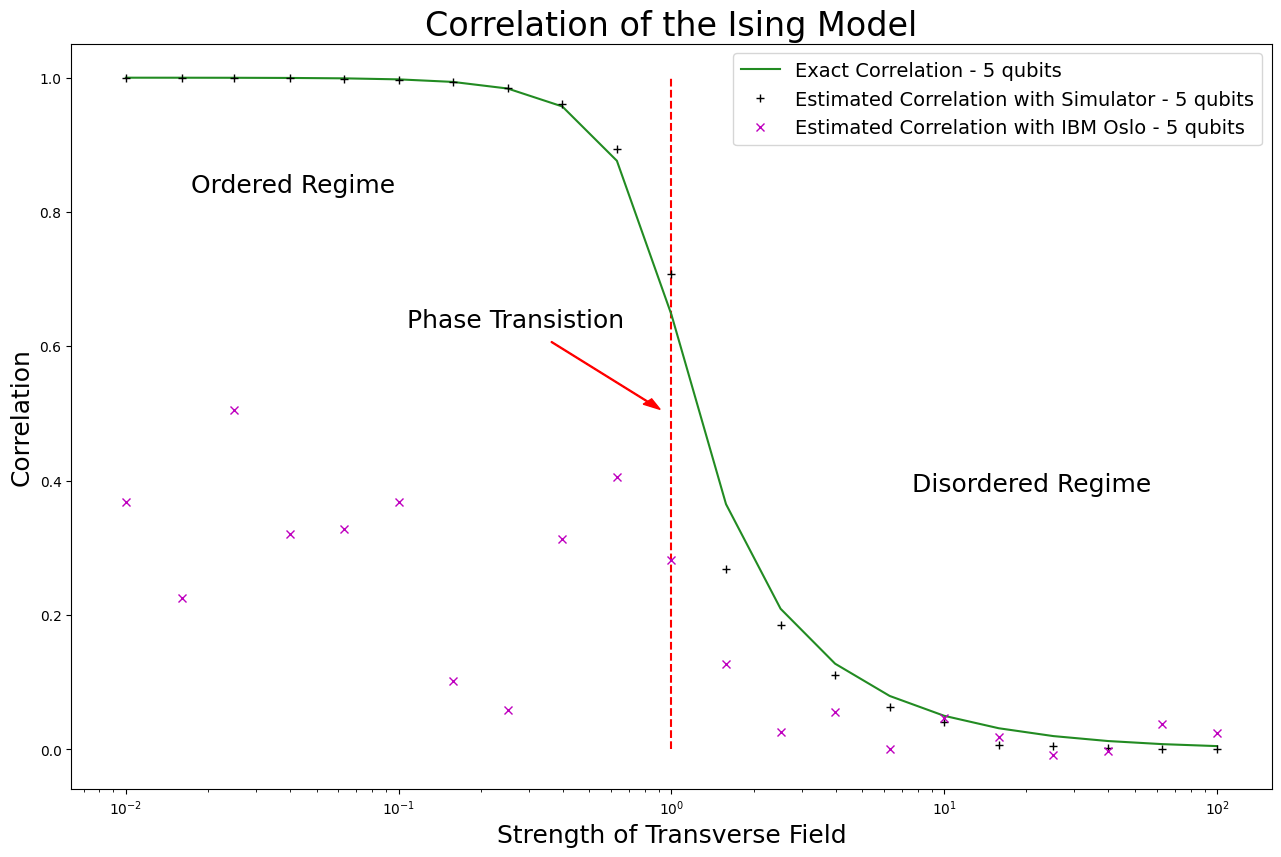

In [262]:
## redo graph with loaded data

d_text_coords = (0.7,0.4)
o_text_coords = (0.1,0.8)
arr_coords = (0.4, 0.6, 0.08, -0.08)
lab_coords = (0.28, 0.62)

fig_c_q, ax_c_q = plot_correlations(5,gs,exact_corrs, est_corrs,
                  quantum = True, 
                  gs_q = gs_q, exact_corrs_q = exact_corrs_q, est_corrs_q = est_corrs_q)


fig_c_q, ax_c_q = write_text(fig_c_q,ax_c_q, o_text_coords,d_text_coords, arr_coords, lab_coords)
fig_c_q.savefig(os.path.join(os.getcwd(), "images", "Correlation_5_qubits_quantum_reformat.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


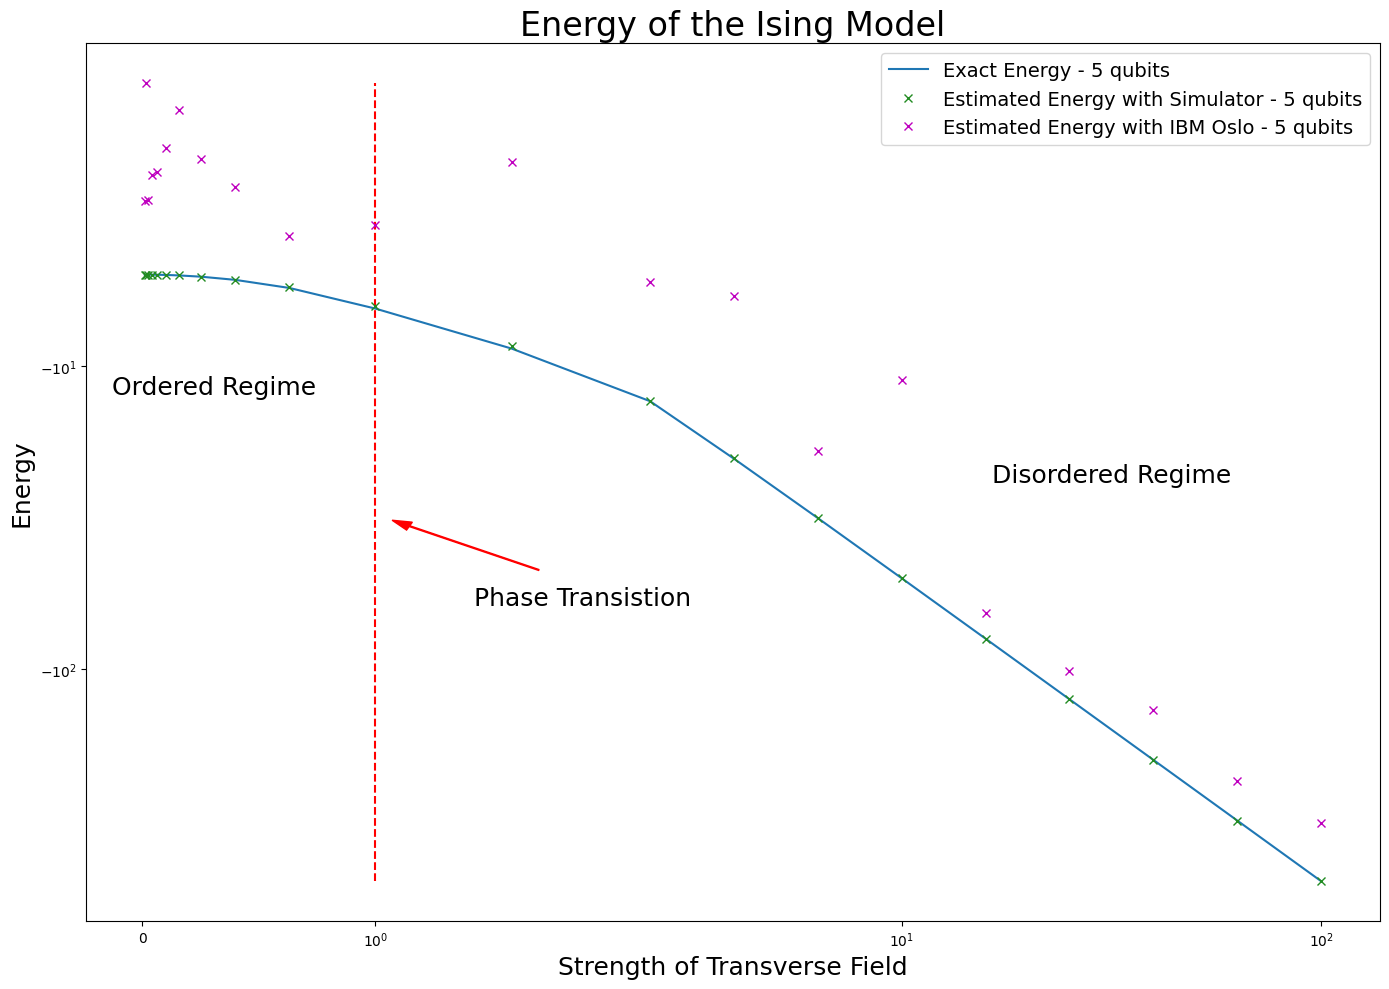

In [267]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.02,0.6)
arr_coords = (0.35, 0.4, -0.1, 0.05)
lab_coords = (0.30, 0.36)

fig_e_q, ax_e_q = plot_energies(5,gs,exact_energies, est_energies,
                  quantum = True, 
                  gs_q = gs_q, exact_energies_q = exact_energies_q, est_energies_q = est_energies_q)

fig_e_q, ax_e_q = write_text(fig_e_q,ax_e_q, o_text_coords,d_text_coords, arr_coords, lab_coords)

fig_e_q.savefig(os.path.join(os.getcwd(), "images", "Energy_5_qubits_quantum_reformat.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


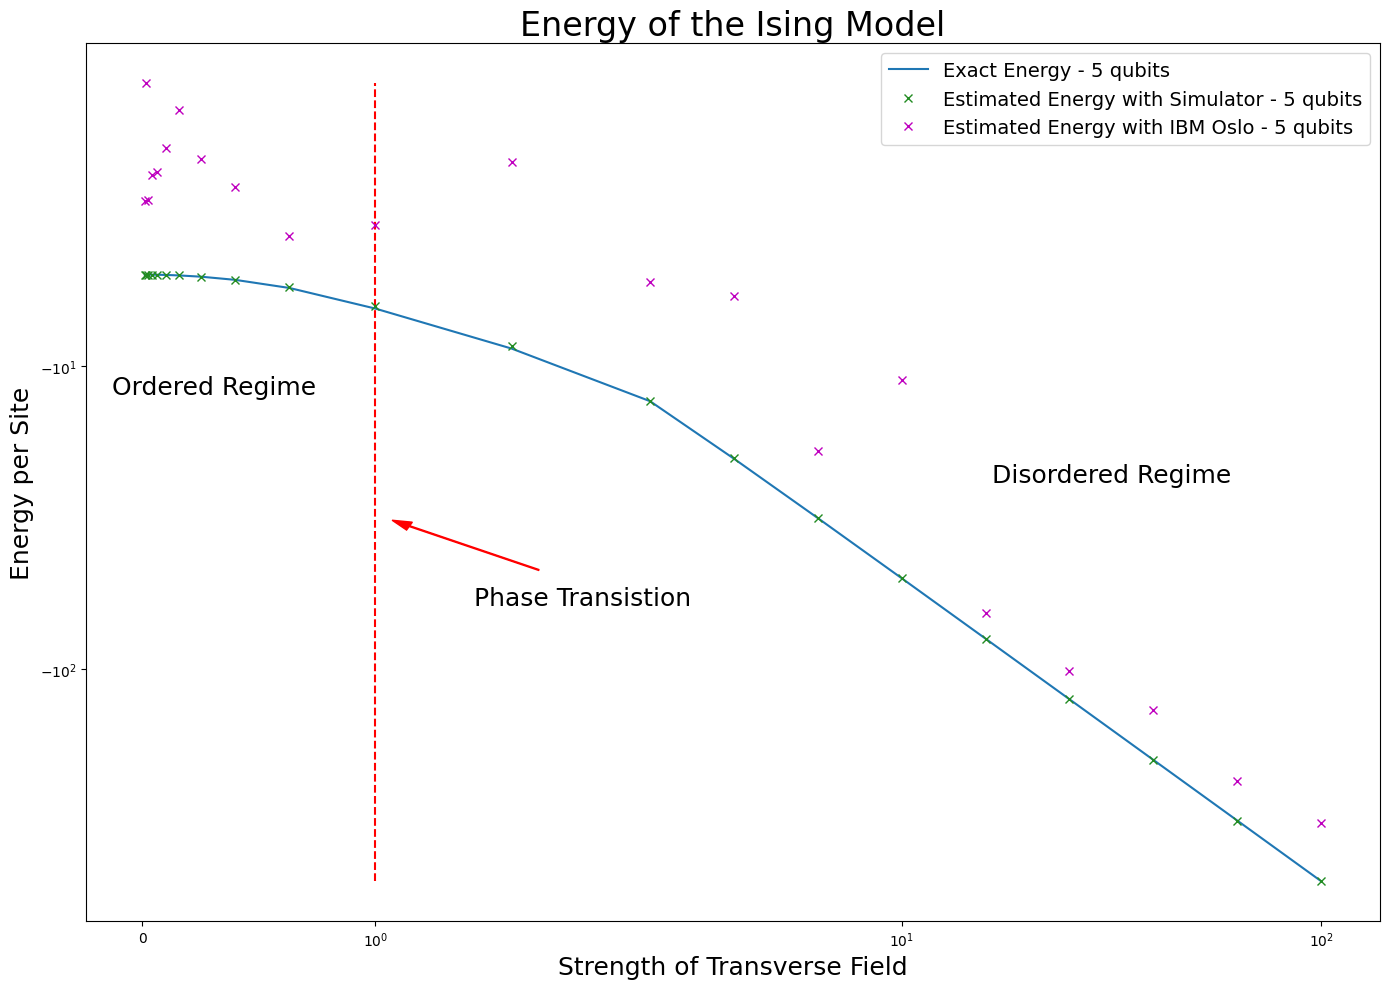

In [266]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.02,0.6)
arr_coords = (0.35, 0.4, -0.1, 0.05)
lab_coords = (0.30, 0.36)

fig_e_q, ax_e_q = plot_energies(5,gs,exact_energies, est_energies,
                  quantum = True, 
                  gs_q = gs_q, exact_energies_q = exact_energies_q, est_energies_q = est_energies_q, per_site = True)

fig_e_q, ax_e_q = write_text(fig_e_q,ax_e_q, o_text_coords,d_text_coords, arr_coords, lab_coords)

fig_e_q.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_5_qubits_quantum_reformat.jpg"))